In [3]:
# Base packages
import numpy
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import *

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

Evaluate your models!
Matching training data well is just the start.

- Split your data into training and test sets.
- Fit the model with the training set.
- Evaluate the model on the test set.
- Develop an error function to evaluate the model.

The amount to split your data varies, but say 30-40% for testing, done with sklearn:

In [4]:
X, y, x_ideal, y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

# Splitting step
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)


X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


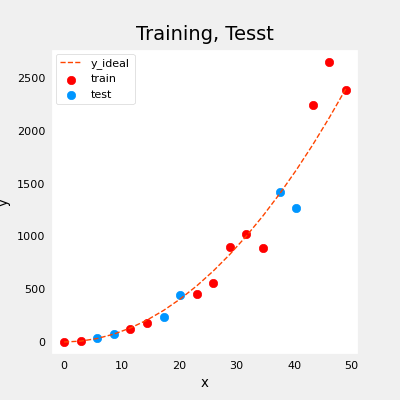

In [6]:
# Plot the data for illustrative purposes.
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color="orangered", label="y_ideal", lw=1)
ax.set_title("Training, Tesst", fontsize=14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color="red", label="train")
ax.scatter(X_test, y_test, color=dlc["dlblue"], label="test")
ax.legend(loc="upper left")
plt.show()


When evaluating a lin-reg model, average sq. error.

In [14]:
def eval_mse(y, yhat):
    """
    Calculate the mean squared error on a data set.
    Args:
        y   : (ndarray Shape (m,) or (m, 1)) target value of each example.
        yhat: (ndarray Shape (m,) or (m, 1)) predicted value of each example.
    Returns:
        err: (scalar)
    """
    return (1 / (2 * len(y))) * np.sum(np.power(np.subtract(y, yhat), 2))
    
    

In [16]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])

eval_mse(y_tmp, y_hat) # Expect ~0.005

0.0050000000000000305

Now, build a high-degree model to minimize error with sklearn.
- Create and fit the model.
- Compute error on training data.
- Compute error on test data.
(You should expect training error to be much lower)

In [18]:
# Create the model with sklearn
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# Predict on training data and find error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# Ditto on test data
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

print("Training error:\t", err_train, "\nTest error:\t", err_test)


Training error:	 58.007560352786506 
Test error:	 171215.01148835945


That's an overfit meatball.
Plot it! (Degree 10 is definitely too much)

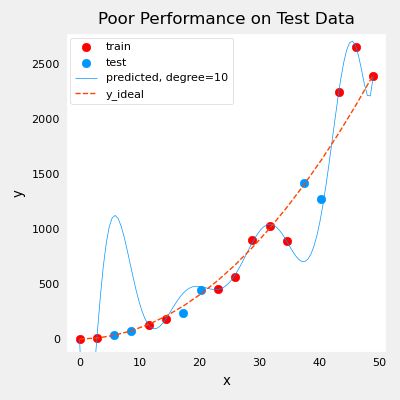

In [20]:
x = np.linspace(0, int(X.max()), 100)
y_pred = lmodel.predict(x).reshape(-1, 1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

Well, better take into account some cross validation data, as previously suggested.
Train, Test, CV = .6, .2, .2, by convention.
Training - tune model parameters w, b
CV - tune other params, degree, regularization, neural architecture
Test - Gauge performance on new data

In [24]:
# Generate data
X, y, x_ideal, y_ideal = gen_data(40, 5, 0.7)
print("X.shape:", X.shape, "\t\ty.shape:", y.shape)

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.50, random_state=1)
print("X_train.shape:", X_train.shape, "\ty_train.shape:", y_train.shape)
print("X_cv.shape:", X_cv.shape, "\ty_cv.shape:", y_cv.shape)
print("X_test.shape:", X_test.shape, "\ty_test.shape:", y_test.shape)


X.shape: (40,) 		y.shape: (40,)
X_train.shape: (24,) 	y_train.shape: (24,)
X_cv.shape: (8,) 	y_cv.shape: (8,)
X_test.shape: (8,) 	y_test.shape: (8,)


So we want to minimize the costs of the cross-validation set while having the cost on the training set be as low as possible (before testing).

As you plot the degree of polynomial against these errors, you can see the optimal angle in some cases, but trying a range of values probably works better, because ML is just brute forcing things because we don't wanna think about them, so here's a whole ass new field of study to be smrt in!

As degree gets too high, the error will increase again, degrading performance and indicating overfit.

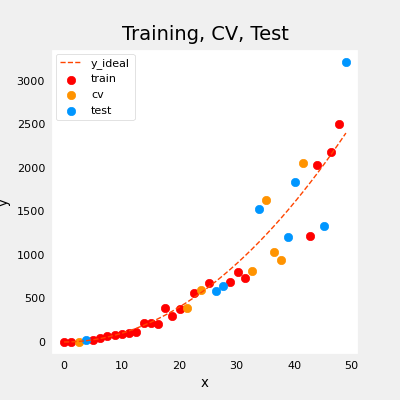

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color="orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test", fontsize=14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color="red", label="train")
ax.scatter(X_cv, y_cv, color=dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test, color=dlc["dlblue"], label="test")
ax.legend(loc="upper left")
plt.show()

Previously, we saw you can create a model capable of fitting curves with a polynomial (Course 1, Wk2, Feature Eng. and Poly Reg) - we know overfit is bad.

So one way is to train the model repeatedly with varying degrees and see when the overfit starts to kick in.

In [27]:
max_degree = 9 # 10 is for sure too much
err_train = np.zeros(max_degree)
err_cv = np.zeros(max_degree)
x = np.linspace(0, int(X.max()), 100)
y_pred = np.zeros((100, max_degree)) # cols = lines to plot

for degree in range(max_degree): # Probably a neater way to do this, and one that terminates early on increased error 
    lmodel = lin_model(degree + 1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:, degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv) + 1

print(optimal_degree)


2


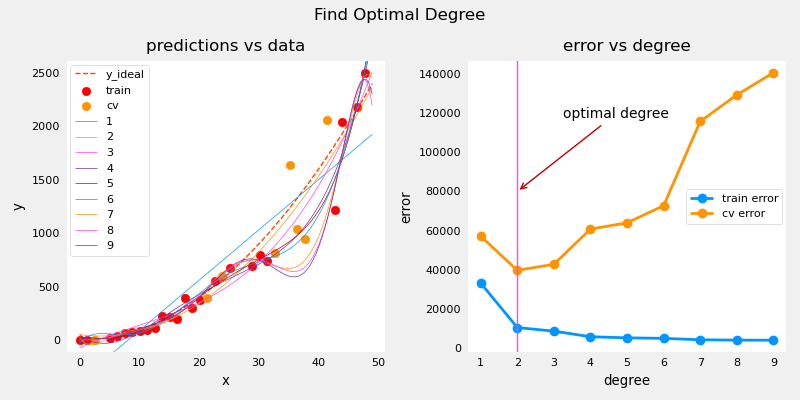

In [28]:
# Plot plot plot
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, err_train, err_cv, optimal_degree, max_degree)

We can also make use of the CV set to tune the regularization value, $\lambda$
Demo by starting with high degree and varying reg param:

In [29]:
lambda_range = np.array([
    0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100
])

num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)
err_cv = np.zeros(num_steps)
x = np.linspace(0, int(X.max()), 100)
y_pred = np.zeros((100, num_steps)) # cols are lines to plot

for i in range(num_steps):
    lambda_ = lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:, i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv)
print(optimal_reg_idx)


7


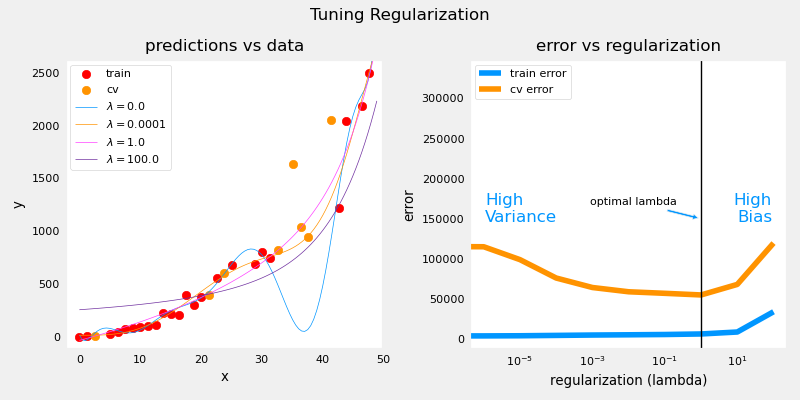

In [30]:
# Plot it
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

So starting with the overfit degree 10, with too low regularization, we continue to overfit (high var), and with too much reg, we underfit (high bias)

One way to solve overfit is to gather more data

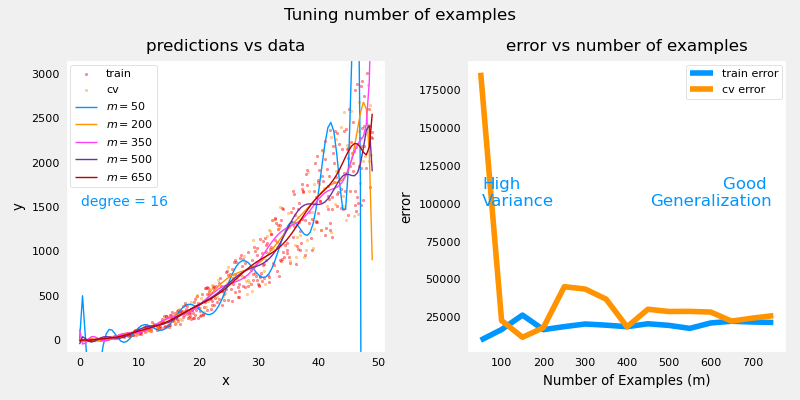

In [31]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

Hey, look! We know degree 16 is way too high, but with enough extra data, it's actually performing alright! This won't work with underfitting examples.

To do a similar thing with neural nets, here's a classification data set:

In [33]:
# Generate and split
X, y, centers, classes, std = gen_blobs()

# Split it - unusually large CV for demo purposes
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.20, random_state=1)

print("X train:", X_train.shape, "\nX cv:", X_cv.shape, "\nX test:", X_test.shape)

X train: (400, 2) 
X cv: (320, 2) 
X test: (80, 2)


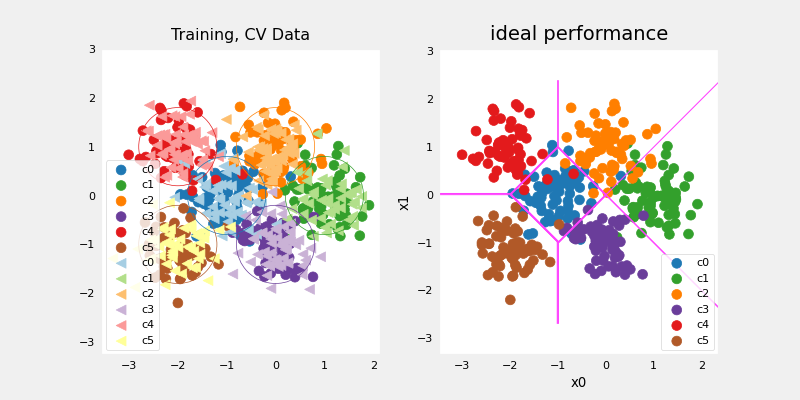

In [34]:
plt_train_eq_dist(X_train, y_train, classes, X_cv, y_cv, centers, std)

Evaluate categorical model by calculating classification error.
This is simply the fraction of incorrect predictions.

In [38]:
def eval_car_err(y, yhat):
    """
    Calculate the categorization error
    Args:
        y    : (ndarray Shape (m,) or (m, 1))  target value of each example
        yhat : (ndarray Shape (m,) or (m, 1))  predicted value of each example
    Returns:
        cerr : (scalar)
    """
    return np.sum(np.not_equal(y, yhat)) / len(y)
    

Now to build models - a simple and complex one. Evaluate them to determine likelihood of over/underfitting.

- A 3-layer model
    - Dense 120, relu
    - Dense 40, relu
    - Dense 6, linear (not softmax)

- Compiled using:
    - SparseCategoricalCrossentropy loss (from_logits=True)
    - Adam optimizer, learn rate 0.01

In [43]:
tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(120, activation="relu"),
        Dense(40, activation="relu"),
        Dense(6)
    ], name="Complex"
)

model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01)
)

In [45]:
model.fit(X_train, y_train, epochs=1000)

Epoch 1/1000
13/13 [==============================] - 0s 660us/step - loss: 0.0270
Epoch 2/1000
13/13 [==============================] - 0s 413us/step - loss: 0.0239
Epoch 3/1000
13/13 [==============================] - 0s 576us/step - loss: 0.0261
Epoch 4/1000
13/13 [==============================] - 0s 517us/step - loss: 0.0232
Epoch 5/1000
13/13 [==============================] - 0s 518us/step - loss: 0.0245
Epoch 6/1000
13/13 [==============================] - 0s 483us/step - loss: 0.0223
Epoch 7/1000
13/13 [==============================] - 0s 642us/step - loss: 0.0237
Epoch 8/1000
13/13 [==============================] - 0s 558us/step - loss: 0.0234
Epoch 9/1000
13/13 [==============================] - 0s 578us/step - loss: 0.0214
Epoch 10/1000
13/13 [==============================] - 0s 513us/step - loss: 0.0209
Epoch 11/1000
13/13 [==============================] - 0s 655us/step - loss: 0.0251
Epoch 12/1000
13/13 [==============================] - 0s 622us/step - loss: 0.0292
E

13/13 [==============================] - 0s 576us/step - loss: 0.0222
Epoch 99/1000
13/13 [==============================] - 0s 632us/step - loss: 0.0200
Epoch 100/1000
13/13 [==============================] - 0s 557us/step - loss: 0.0187
Epoch 101/1000
13/13 [==============================] - 0s 522us/step - loss: 0.0190
Epoch 102/1000
13/13 [==============================] - 0s 601us/step - loss: 0.0176
Epoch 103/1000
13/13 [==============================] - 0s 596us/step - loss: 0.0180
Epoch 104/1000
13/13 [==============================] - 0s 516us/step - loss: 0.0203
Epoch 105/1000
13/13 [==============================] - 0s 539us/step - loss: 0.0207
Epoch 106/1000
13/13 [==============================] - 0s 613us/step - loss: 0.0196
Epoch 107/1000
13/13 [==============================] - 0s 552us/step - loss: 0.0200
Epoch 108/1000
13/13 [==============================] - 0s 583us/step - loss: 0.0175
Epoch 109/1000
13/13 [==============================] - 0s 727us/step - loss: 0.0

13/13 [==============================] - 0s 577us/step - loss: 0.0322
Epoch 195/1000
13/13 [==============================] - 0s 617us/step - loss: 0.0238
Epoch 196/1000
13/13 [==============================] - 0s 621us/step - loss: 0.0342
Epoch 197/1000
13/13 [==============================] - 0s 601us/step - loss: 0.0345
Epoch 198/1000
13/13 [==============================] - 0s 458us/step - loss: 0.0378
Epoch 199/1000
13/13 [==============================] - 0s 605us/step - loss: 0.0262
Epoch 200/1000
13/13 [==============================] - 0s 469us/step - loss: 0.0282
Epoch 201/1000
13/13 [==============================] - 0s 614us/step - loss: 0.0208
Epoch 202/1000
13/13 [==============================] - 0s 547us/step - loss: 0.0206
Epoch 203/1000
13/13 [==============================] - 0s 572us/step - loss: 0.0189
Epoch 204/1000
13/13 [==============================] - 0s 567us/step - loss: 0.0189
Epoch 205/1000
13/13 [==============================] - 0s 583us/step - loss: 0.

13/13 [==============================] - 0s 552us/step - loss: 0.0175
Epoch 291/1000
13/13 [==============================] - 0s 572us/step - loss: 0.0266
Epoch 292/1000
13/13 [==============================] - 0s 618us/step - loss: 0.0274
Epoch 293/1000
13/13 [==============================] - 0s 580us/step - loss: 0.0323
Epoch 294/1000
13/13 [==============================] - 0s 520us/step - loss: 0.0259
Epoch 295/1000
13/13 [==============================] - 0s 550us/step - loss: 0.0310
Epoch 296/1000
13/13 [==============================] - 0s 552us/step - loss: 0.0326
Epoch 297/1000
13/13 [==============================] - 0s 583us/step - loss: 0.0212
Epoch 298/1000
13/13 [==============================] - 0s 537us/step - loss: 0.0209
Epoch 299/1000
13/13 [==============================] - 0s 533us/step - loss: 0.0273
Epoch 300/1000
13/13 [==============================] - 0s 507us/step - loss: 0.0302
Epoch 301/1000
13/13 [==============================] - 0s 483us/step - loss: 0.

13/13 [==============================] - 0s 578us/step - loss: 0.0194
Epoch 387/1000
13/13 [==============================] - 0s 628us/step - loss: 0.0196
Epoch 388/1000
13/13 [==============================] - 0s 649us/step - loss: 0.0203
Epoch 389/1000
13/13 [==============================] - 0s 515us/step - loss: 0.0199
Epoch 390/1000
13/13 [==============================] - 0s 627us/step - loss: 0.0215
Epoch 391/1000
13/13 [==============================] - 0s 479us/step - loss: 0.0185
Epoch 392/1000
13/13 [==============================] - 0s 503us/step - loss: 0.0213
Epoch 393/1000
13/13 [==============================] - 0s 443us/step - loss: 0.0200
Epoch 394/1000
13/13 [==============================] - 0s 427us/step - loss: 0.0187
Epoch 395/1000
13/13 [==============================] - 0s 607us/step - loss: 0.0174
Epoch 396/1000
13/13 [==============================] - 0s 590us/step - loss: 0.0206
Epoch 397/1000
13/13 [==============================] - 0s 527us/step - loss: 0.

13/13 [==============================] - 0s 511us/step - loss: 0.0160
Epoch 483/1000
13/13 [==============================] - 0s 602us/step - loss: 0.0175
Epoch 484/1000
13/13 [==============================] - 0s 564us/step - loss: 0.0178
Epoch 485/1000
13/13 [==============================] - 0s 594us/step - loss: 0.0185
Epoch 486/1000
13/13 [==============================] - 0s 616us/step - loss: 0.0183
Epoch 487/1000
13/13 [==============================] - 0s 564us/step - loss: 0.0203
Epoch 488/1000
13/13 [==============================] - 0s 525us/step - loss: 0.0172
Epoch 489/1000
13/13 [==============================] - 0s 503us/step - loss: 0.0172
Epoch 490/1000
13/13 [==============================] - 0s 604us/step - loss: 0.0174
Epoch 491/1000
13/13 [==============================] - 0s 455us/step - loss: 0.0159
Epoch 492/1000
13/13 [==============================] - 0s 554us/step - loss: 0.0172
Epoch 493/1000
13/13 [==============================] - 0s 577us/step - loss: 0.

13/13 [==============================] - 0s 608us/step - loss: 0.0464
Epoch 579/1000
13/13 [==============================] - 0s 580us/step - loss: 0.0255
Epoch 580/1000
13/13 [==============================] - 0s 485us/step - loss: 0.0222
Epoch 581/1000
13/13 [==============================] - 0s 524us/step - loss: 0.0166
Epoch 582/1000
13/13 [==============================] - 0s 594us/step - loss: 0.0166
Epoch 583/1000
13/13 [==============================] - 0s 465us/step - loss: 0.0209
Epoch 584/1000
13/13 [==============================] - 0s 562us/step - loss: 0.0352
Epoch 585/1000
13/13 [==============================] - 0s 582us/step - loss: 0.0384
Epoch 586/1000
13/13 [==============================] - 0s 538us/step - loss: 0.1332
Epoch 587/1000
13/13 [==============================] - 0s 501us/step - loss: 0.0556
Epoch 588/1000
13/13 [==============================] - 0s 606us/step - loss: 0.0401
Epoch 589/1000
13/13 [==============================] - 0s 475us/step - loss: 0.

13/13 [==============================] - 0s 509us/step - loss: 0.2251
Epoch 675/1000
13/13 [==============================] - 0s 569us/step - loss: 0.1573
Epoch 676/1000
13/13 [==============================] - 0s 554us/step - loss: 0.1119
Epoch 677/1000
13/13 [==============================] - 0s 581us/step - loss: 0.1884
Epoch 678/1000
13/13 [==============================] - 0s 596us/step - loss: 0.1619
Epoch 679/1000
13/13 [==============================] - 0s 512us/step - loss: 0.0913
Epoch 680/1000
13/13 [==============================] - 0s 541us/step - loss: 0.0587
Epoch 681/1000
13/13 [==============================] - 0s 551us/step - loss: 0.0335
Epoch 682/1000
13/13 [==============================] - 0s 619us/step - loss: 0.0277
Epoch 683/1000
13/13 [==============================] - 0s 588us/step - loss: 0.0268
Epoch 684/1000
13/13 [==============================] - 0s 615us/step - loss: 0.0189
Epoch 685/1000
13/13 [==============================] - 0s 520us/step - loss: 0.

13/13 [==============================] - 0s 501us/step - loss: 0.0127
Epoch 771/1000
13/13 [==============================] - 0s 631us/step - loss: 0.0116
Epoch 772/1000
13/13 [==============================] - 0s 615us/step - loss: 0.0109
Epoch 773/1000
13/13 [==============================] - 0s 604us/step - loss: 0.0110
Epoch 774/1000
13/13 [==============================] - 0s 472us/step - loss: 0.0124
Epoch 775/1000
13/13 [==============================] - 0s 647us/step - loss: 0.0114
Epoch 776/1000
13/13 [==============================] - 0s 535us/step - loss: 0.0128
Epoch 777/1000
13/13 [==============================] - 0s 622us/step - loss: 0.0117
Epoch 778/1000
13/13 [==============================] - 0s 503us/step - loss: 0.0103
Epoch 779/1000
13/13 [==============================] - 0s 506us/step - loss: 0.0132
Epoch 780/1000
13/13 [==============================] - 0s 407us/step - loss: 0.0136
Epoch 781/1000
13/13 [==============================] - 0s 503us/step - loss: 0.

13/13 [==============================] - 0s 555us/step - loss: 0.0123
Epoch 867/1000
13/13 [==============================] - 0s 537us/step - loss: 0.0142
Epoch 868/1000
13/13 [==============================] - 0s 456us/step - loss: 0.0160
Epoch 869/1000
13/13 [==============================] - 0s 596us/step - loss: 0.0130
Epoch 870/1000
13/13 [==============================] - 0s 435us/step - loss: 0.0162
Epoch 871/1000
13/13 [==============================] - 0s 549us/step - loss: 0.0139
Epoch 872/1000
13/13 [==============================] - 0s 498us/step - loss: 0.0134
Epoch 873/1000
13/13 [==============================] - 0s 665us/step - loss: 0.0132
Epoch 874/1000
13/13 [==============================] - 0s 532us/step - loss: 0.0166
Epoch 875/1000
13/13 [==============================] - 0s 654us/step - loss: 0.0173
Epoch 876/1000
13/13 [==============================] - 0s 607us/step - loss: 0.0145
Epoch 877/1000
13/13 [==============================] - 0s 639us/step - loss: 0.

13/13 [==============================] - 0s 588us/step - loss: 0.0129
Epoch 963/1000
13/13 [==============================] - 0s 647us/step - loss: 0.0128
Epoch 964/1000
13/13 [==============================] - 0s 569us/step - loss: 0.0119
Epoch 965/1000
13/13 [==============================] - 0s 591us/step - loss: 0.0140
Epoch 966/1000
13/13 [==============================] - 0s 567us/step - loss: 0.0127
Epoch 967/1000
13/13 [==============================] - 0s 474us/step - loss: 0.0136
Epoch 968/1000
13/13 [==============================] - 0s 491us/step - loss: 0.0132
Epoch 969/1000
13/13 [==============================] - 0s 617us/step - loss: 0.0133
Epoch 970/1000
13/13 [==============================] - 0s 531us/step - loss: 0.0127
Epoch 971/1000
13/13 [==============================] - 0s 605us/step - loss: 0.0137
Epoch 972/1000
13/13 [==============================] - 0s 489us/step - loss: 0.0137
Epoch 973/1000
13/13 [==============================] - 0s 583us/step - loss: 0.

In [46]:
model.summary()
model_test(model, classes, X_train.shape[1])

Model: "Complex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 120)               360       
_________________________________________________________________
dense_4 (Dense)              (None, 40)                4840      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 246       
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
All tests passed!


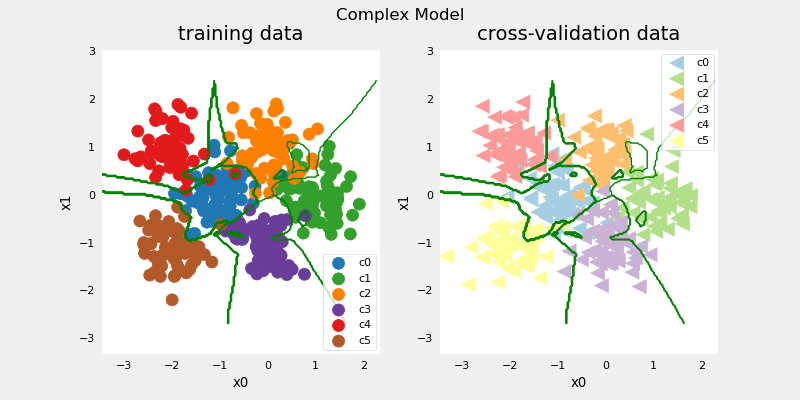

In [47]:
# Make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(), axis=1)
plt_nn(model_predict, X_train, y_train, classes, X_cv, y_cv, suptitle="Complex Model")

In [48]:
# Looks bad, calc the classification error:
training_cerr_complex = eval_car_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_car_err(y_cv, model_predict(X_cv))

print("Cat err, training, complex:\t", training_cerr_complex)
print("Cat err, CV, complex:\t\t", cv_cerr_complex)

Cat err, training, complex:	 0.0025
Cat err, CV, complex:		 0.121875


So let's simplify.
- 2-layer model
    - Dense 6, relu
    - Dense 6, linear

- Compile with
    - SparseCategoricalCrossentropy, from_logits=True
    - Adam, learning = 0.01

In [49]:
model_s = Sequential(
    [
        Dense(6, activation="relu"),
        Dense(6)
    ], name="Simple"
)
model_s.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01)
)

In [50]:
model_s.fit(X_train, y_train, epochs=1000)

Epoch 1/1000
13/13 [==============================] - 0s 588us/step - loss: 1.5417
Epoch 2/1000
13/13 [==============================] - 0s 426us/step - loss: 1.3016
Epoch 3/1000
13/13 [==============================] - 0s 347us/step - loss: 1.0945
Epoch 4/1000
13/13 [==============================] - 0s 444us/step - loss: 0.9632
Epoch 5/1000
13/13 [==============================] - 0s 389us/step - loss: 0.7628
Epoch 6/1000
13/13 [==============================] - 0s 296us/step - loss: 0.6530
Epoch 7/1000
13/13 [==============================] - 0s 326us/step - loss: 0.5302
Epoch 8/1000
13/13 [==============================] - 0s 313us/step - loss: 0.4600
Epoch 9/1000
13/13 [==============================] - 0s 298us/step - loss: 0.4267
Epoch 10/1000
13/13 [==============================] - 0s 239us/step - loss: 0.3743
Epoch 11/1000
13/13 [==============================] - 0s 337us/step - loss: 0.3440
Epoch 12/1000
13/13 [==============================] - 0s 457us/step - loss: 0.3496
E

13/13 [==============================] - 0s 327us/step - loss: 0.1754
Epoch 99/1000
13/13 [==============================] - 0s 349us/step - loss: 0.1798
Epoch 100/1000
13/13 [==============================] - 0s 297us/step - loss: 0.1941
Epoch 101/1000
13/13 [==============================] - 0s 458us/step - loss: 0.1701
Epoch 102/1000
13/13 [==============================] - 0s 393us/step - loss: 0.2001
Epoch 103/1000
13/13 [==============================] - 0s 463us/step - loss: 0.1693
Epoch 104/1000
13/13 [==============================] - 0s 526us/step - loss: 0.1922
Epoch 105/1000
13/13 [==============================] - 0s 446us/step - loss: 0.1786
Epoch 106/1000
13/13 [==============================] - 0s 373us/step - loss: 0.1803
Epoch 107/1000
13/13 [==============================] - 0s 461us/step - loss: 0.1801
Epoch 108/1000
13/13 [==============================] - 0s 299us/step - loss: 0.1575
Epoch 109/1000
13/13 [==============================] - 0s 321us/step - loss: 0.2

13/13 [==============================] - 0s 399us/step - loss: 0.1662
Epoch 195/1000
13/13 [==============================] - 0s 284us/step - loss: 0.2253
Epoch 196/1000
13/13 [==============================] - 0s 460us/step - loss: 0.1820
Epoch 197/1000
13/13 [==============================] - 0s 405us/step - loss: 0.1783
Epoch 198/1000
13/13 [==============================] - 0s 281us/step - loss: 0.1718
Epoch 199/1000
13/13 [==============================] - 0s 337us/step - loss: 0.1915
Epoch 200/1000
13/13 [==============================] - 0s 379us/step - loss: 0.1725
Epoch 201/1000
13/13 [==============================] - 0s 300us/step - loss: 0.1749
Epoch 202/1000
13/13 [==============================] - 0s 376us/step - loss: 0.2027
Epoch 203/1000
13/13 [==============================] - 0s 456us/step - loss: 0.1680
Epoch 204/1000
13/13 [==============================] - 0s 297us/step - loss: 0.1967
Epoch 205/1000
13/13 [==============================] - 0s 408us/step - loss: 0.

13/13 [==============================] - 0s 254us/step - loss: 0.1754
Epoch 291/1000
13/13 [==============================] - 0s 303us/step - loss: 0.1821
Epoch 292/1000
13/13 [==============================] - 0s 389us/step - loss: 0.2274
Epoch 293/1000
13/13 [==============================] - 0s 281us/step - loss: 0.1837
Epoch 294/1000
13/13 [==============================] - 0s 296us/step - loss: 0.1423
Epoch 295/1000
13/13 [==============================] - 0s 315us/step - loss: 0.2187
Epoch 296/1000
13/13 [==============================] - 0s 288us/step - loss: 0.1617
Epoch 297/1000
13/13 [==============================] - 0s 401us/step - loss: 0.1765
Epoch 298/1000
13/13 [==============================] - 0s 346us/step - loss: 0.1699
Epoch 299/1000
13/13 [==============================] - 0s 294us/step - loss: 0.1642
Epoch 300/1000
13/13 [==============================] - 0s 321us/step - loss: 0.1644
Epoch 301/1000
13/13 [==============================] - 0s 353us/step - loss: 0.

13/13 [==============================] - 0s 286us/step - loss: 0.1668
Epoch 387/1000
13/13 [==============================] - 0s 296us/step - loss: 0.1801
Epoch 388/1000
13/13 [==============================] - 0s 286us/step - loss: 0.1689
Epoch 389/1000
13/13 [==============================] - 0s 425us/step - loss: 0.1578
Epoch 390/1000
13/13 [==============================] - 0s 330us/step - loss: 0.1570
Epoch 391/1000
13/13 [==============================] - 0s 287us/step - loss: 0.1709
Epoch 392/1000
13/13 [==============================] - 0s 321us/step - loss: 0.1996
Epoch 393/1000
13/13 [==============================] - 0s 281us/step - loss: 0.1901
Epoch 394/1000
13/13 [==============================] - 0s 292us/step - loss: 0.1732
Epoch 395/1000
13/13 [==============================] - 0s 285us/step - loss: 0.1571
Epoch 396/1000
13/13 [==============================] - 0s 494us/step - loss: 0.2278
Epoch 397/1000
13/13 [==============================] - 0s 322us/step - loss: 0.

13/13 [==============================] - 0s 396us/step - loss: 0.2021
Epoch 483/1000
13/13 [==============================] - 0s 269us/step - loss: 0.1649
Epoch 484/1000
13/13 [==============================] - 0s 259us/step - loss: 0.1527
Epoch 485/1000
13/13 [==============================] - 0s 300us/step - loss: 0.1637
Epoch 486/1000
13/13 [==============================] - 0s 299us/step - loss: 0.1697
Epoch 487/1000
13/13 [==============================] - 0s 289us/step - loss: 0.1751
Epoch 488/1000
13/13 [==============================] - 0s 393us/step - loss: 0.1694
Epoch 489/1000
13/13 [==============================] - 0s 414us/step - loss: 0.1820
Epoch 490/1000
13/13 [==============================] - 0s 277us/step - loss: 0.1880
Epoch 491/1000
13/13 [==============================] - 0s 378us/step - loss: 0.1988
Epoch 492/1000
13/13 [==============================] - 0s 436us/step - loss: 0.2249
Epoch 493/1000
13/13 [==============================] - 0s 309us/step - loss: 0.

13/13 [==============================] - 0s 397us/step - loss: 0.2021
Epoch 579/1000
13/13 [==============================] - 0s 371us/step - loss: 0.1819
Epoch 580/1000
13/13 [==============================] - 0s 273us/step - loss: 0.1894
Epoch 581/1000
13/13 [==============================] - 0s 325us/step - loss: 0.1993
Epoch 582/1000
13/13 [==============================] - 0s 302us/step - loss: 0.1758
Epoch 583/1000
13/13 [==============================] - 0s 399us/step - loss: 0.2230
Epoch 584/1000
13/13 [==============================] - 0s 365us/step - loss: 0.1669
Epoch 585/1000
13/13 [==============================] - 0s 340us/step - loss: 0.1470
Epoch 586/1000
13/13 [==============================] - 0s 285us/step - loss: 0.1768
Epoch 587/1000
13/13 [==============================] - 0s 243us/step - loss: 0.1885
Epoch 588/1000
13/13 [==============================] - 0s 442us/step - loss: 0.1919
Epoch 589/1000
13/13 [==============================] - 0s 421us/step - loss: 0.

13/13 [==============================] - 0s 333us/step - loss: 0.1755
Epoch 675/1000
13/13 [==============================] - 0s 292us/step - loss: 0.1592
Epoch 676/1000
13/13 [==============================] - 0s 286us/step - loss: 0.1956
Epoch 677/1000
13/13 [==============================] - 0s 354us/step - loss: 0.1480
Epoch 678/1000
13/13 [==============================] - 0s 281us/step - loss: 0.1772
Epoch 679/1000
13/13 [==============================] - 0s 277us/step - loss: 0.1763
Epoch 680/1000
13/13 [==============================] - 0s 350us/step - loss: 0.1658
Epoch 681/1000
13/13 [==============================] - 0s 352us/step - loss: 0.1507
Epoch 682/1000
13/13 [==============================] - 0s 275us/step - loss: 0.1615
Epoch 683/1000
13/13 [==============================] - 0s 404us/step - loss: 0.1421
Epoch 684/1000
13/13 [==============================] - 0s 417us/step - loss: 0.1562
Epoch 685/1000
13/13 [==============================] - 0s 266us/step - loss: 0.

13/13 [==============================] - 0s 264us/step - loss: 0.1469
Epoch 771/1000
13/13 [==============================] - 0s 285us/step - loss: 0.1564
Epoch 772/1000
13/13 [==============================] - 0s 310us/step - loss: 0.2053
Epoch 773/1000
13/13 [==============================] - 0s 286us/step - loss: 0.1670
Epoch 774/1000
13/13 [==============================] - 0s 383us/step - loss: 0.1676
Epoch 775/1000
13/13 [==============================] - 0s 387us/step - loss: 0.1739
Epoch 776/1000
13/13 [==============================] - 0s 303us/step - loss: 0.1620
Epoch 777/1000
13/13 [==============================] - 0s 275us/step - loss: 0.1870
Epoch 778/1000
13/13 [==============================] - 0s 294us/step - loss: 0.2251
Epoch 779/1000
13/13 [==============================] - 0s 296us/step - loss: 0.1472
Epoch 780/1000
13/13 [==============================] - 0s 289us/step - loss: 0.1572
Epoch 781/1000
13/13 [==============================] - 0s 305us/step - loss: 0.

13/13 [==============================] - 0s 311us/step - loss: 0.1803
Epoch 867/1000
13/13 [==============================] - 0s 482us/step - loss: 0.2088
Epoch 868/1000
13/13 [==============================] - 0s 290us/step - loss: 0.2003
Epoch 869/1000
13/13 [==============================] - 0s 342us/step - loss: 0.1645
Epoch 870/1000
13/13 [==============================] - 0s 412us/step - loss: 0.1667
Epoch 871/1000
13/13 [==============================] - 0s 446us/step - loss: 0.1565
Epoch 872/1000
13/13 [==============================] - 0s 283us/step - loss: 0.1895
Epoch 873/1000
13/13 [==============================] - 0s 285us/step - loss: 0.1719
Epoch 874/1000
13/13 [==============================] - 0s 435us/step - loss: 0.1781
Epoch 875/1000
13/13 [==============================] - 0s 298us/step - loss: 0.1473
Epoch 876/1000
13/13 [==============================] - 0s 317us/step - loss: 0.1504
Epoch 877/1000
13/13 [==============================] - 0s 278us/step - loss: 0.

13/13 [==============================] - 0s 413us/step - loss: 0.1677
Epoch 963/1000
13/13 [==============================] - 0s 294us/step - loss: 0.1667
Epoch 964/1000
13/13 [==============================] - 0s 338us/step - loss: 0.1466
Epoch 965/1000
13/13 [==============================] - 0s 326us/step - loss: 0.1915
Epoch 966/1000
13/13 [==============================] - 0s 279us/step - loss: 0.1744
Epoch 967/1000
13/13 [==============================] - 0s 297us/step - loss: 0.1896
Epoch 968/1000
13/13 [==============================] - 0s 300us/step - loss: 0.1406
Epoch 969/1000
13/13 [==============================] - 0s 455us/step - loss: 0.1839
Epoch 970/1000
13/13 [==============================] - 0s 445us/step - loss: 0.1925
Epoch 971/1000
13/13 [==============================] - 0s 500us/step - loss: 0.1394
Epoch 972/1000
13/13 [==============================] - 0s 355us/step - loss: 0.1835
Epoch 973/1000
13/13 [==============================] - 0s 404us/step - loss: 0.

In [52]:
model_s.summary()
model_s_test(model_s, classes, X_train.shape[1])

Model: "Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6)                 18        
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 42        
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
All tests passed!


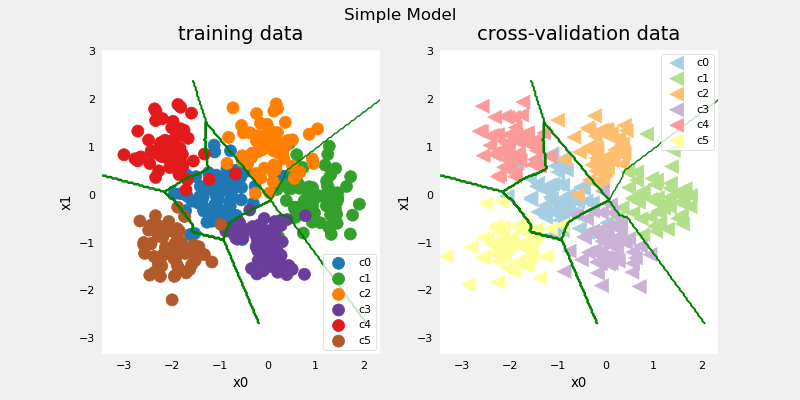

In [53]:
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(), axis=1)
plt_nn(model_predict_s, X_train, y_train, classes, X_cv, y_cv, suptitle="Simple Model")

Looks better. How about the error?

In [54]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))

print("Training:\t", training_cerr_simple)
print("CV:\t\t", cv_cerr_simple)

Training:	 0.0625
CV:		 0.065625


CV error is lower!

Now how about with regularization?

3 Layer model
- Dense 120, relu, kernel_regularizer=tf.keras.regularizers.l2(0.1)
- Dense 40, relu, kernel_regularizer=tf.keras.regularizers.l2(0.1)
- Dense 6, linear

Same compile options.

In [59]:
model_r = Sequential(
    [
        Dense(120, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(40, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(6)
    ]
)
model_r.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01)
)

In [60]:
model_r.fit(X_train, y_train, epochs=1000)

Epoch 1/1000
13/13 [==============================] - 0s 712us/step - loss: 5.7719
Epoch 2/1000
13/13 [==============================] - 0s 564us/step - loss: 1.7479
Epoch 3/1000
13/13 [==============================] - 0s 515us/step - loss: 1.3254
Epoch 4/1000
13/13 [==============================] - 0s 709us/step - loss: 1.1119
Epoch 5/1000
13/13 [==============================] - 0s 594us/step - loss: 0.9676
Epoch 6/1000
13/13 [==============================] - 0s 568us/step - loss: 0.9985
Epoch 7/1000
13/13 [==============================] - 0s 453us/step - loss: 0.9622
Epoch 8/1000
13/13 [==============================] - 0s 613us/step - loss: 0.8971
Epoch 9/1000
13/13 [==============================] - 0s 574us/step - loss: 0.8068
Epoch 10/1000
13/13 [==============================] - 0s 460us/step - loss: 0.7599
Epoch 11/1000
13/13 [==============================] - 0s 539us/step - loss: 0.7423
Epoch 12/1000
13/13 [==============================] - 0s 585us/step - loss: 0.7337
E

13/13 [==============================] - 0s 576us/step - loss: 0.4441
Epoch 99/1000
13/13 [==============================] - 0s 471us/step - loss: 0.4720
Epoch 100/1000
13/13 [==============================] - 0s 628us/step - loss: 0.4910
Epoch 101/1000
13/13 [==============================] - 0s 439us/step - loss: 0.4570
Epoch 102/1000
13/13 [==============================] - 0s 608us/step - loss: 0.4682
Epoch 103/1000
13/13 [==============================] - 0s 583us/step - loss: 0.4335
Epoch 104/1000
13/13 [==============================] - 0s 607us/step - loss: 0.4533
Epoch 105/1000
13/13 [==============================] - 0s 512us/step - loss: 0.4723
Epoch 106/1000
13/13 [==============================] - 0s 547us/step - loss: 0.4767
Epoch 107/1000
13/13 [==============================] - 0s 600us/step - loss: 0.4484
Epoch 108/1000
13/13 [==============================] - 0s 535us/step - loss: 0.4597
Epoch 109/1000
13/13 [==============================] - 0s 392us/step - loss: 0.4

13/13 [==============================] - 0s 512us/step - loss: 0.4089
Epoch 195/1000
13/13 [==============================] - 0s 575us/step - loss: 0.4435
Epoch 196/1000
13/13 [==============================] - 0s 429us/step - loss: 0.4044
Epoch 197/1000
13/13 [==============================] - 0s 466us/step - loss: 0.4117
Epoch 198/1000
13/13 [==============================] - 0s 500us/step - loss: 0.3878
Epoch 199/1000
13/13 [==============================] - 0s 574us/step - loss: 0.4056
Epoch 200/1000
13/13 [==============================] - 0s 513us/step - loss: 0.3995
Epoch 201/1000
13/13 [==============================] - 0s 582us/step - loss: 0.4309
Epoch 202/1000
13/13 [==============================] - 0s 599us/step - loss: 0.4178
Epoch 203/1000
13/13 [==============================] - 0s 613us/step - loss: 0.3791
Epoch 204/1000
13/13 [==============================] - 0s 503us/step - loss: 0.4161
Epoch 205/1000
13/13 [==============================] - 0s 624us/step - loss: 0.

13/13 [==============================] - 0s 571us/step - loss: 0.3907
Epoch 291/1000
13/13 [==============================] - 0s 607us/step - loss: 0.3946
Epoch 292/1000
13/13 [==============================] - 0s 660us/step - loss: 0.4005
Epoch 293/1000
13/13 [==============================] - 0s 615us/step - loss: 0.3672
Epoch 294/1000
13/13 [==============================] - 0s 645us/step - loss: 0.3684
Epoch 295/1000
13/13 [==============================] - 0s 631us/step - loss: 0.4456
Epoch 296/1000
13/13 [==============================] - 0s 531us/step - loss: 0.3584
Epoch 297/1000
13/13 [==============================] - 0s 604us/step - loss: 0.3602
Epoch 298/1000
13/13 [==============================] - 0s 633us/step - loss: 0.3943
Epoch 299/1000
13/13 [==============================] - 0s 556us/step - loss: 0.3820
Epoch 300/1000
13/13 [==============================] - 0s 575us/step - loss: 0.4181
Epoch 301/1000
13/13 [==============================] - 0s 475us/step - loss: 0.

13/13 [==============================] - 0s 616us/step - loss: 0.3579
Epoch 387/1000
13/13 [==============================] - 0s 540us/step - loss: 0.3698
Epoch 388/1000
13/13 [==============================] - 0s 526us/step - loss: 0.3810
Epoch 389/1000
13/13 [==============================] - 0s 560us/step - loss: 0.3415
Epoch 390/1000
13/13 [==============================] - 0s 637us/step - loss: 0.3333
Epoch 391/1000
13/13 [==============================] - 0s 526us/step - loss: 0.3477
Epoch 392/1000
13/13 [==============================] - 0s 697us/step - loss: 0.3830
Epoch 393/1000
13/13 [==============================] - 0s 516us/step - loss: 0.3707
Epoch 394/1000
13/13 [==============================] - 0s 588us/step - loss: 0.3653
Epoch 395/1000
13/13 [==============================] - 0s 545us/step - loss: 0.3795
Epoch 396/1000
13/13 [==============================] - 0s 423us/step - loss: 0.4215
Epoch 397/1000
13/13 [==============================] - 0s 580us/step - loss: 0.

13/13 [==============================] - 0s 559us/step - loss: 0.3838
Epoch 483/1000
13/13 [==============================] - 0s 575us/step - loss: 0.3712
Epoch 484/1000
13/13 [==============================] - 0s 479us/step - loss: 0.3524
Epoch 485/1000
13/13 [==============================] - 0s 568us/step - loss: 0.3718
Epoch 486/1000
13/13 [==============================] - 0s 490us/step - loss: 0.3489
Epoch 487/1000
13/13 [==============================] - 0s 593us/step - loss: 0.3329
Epoch 488/1000
13/13 [==============================] - 0s 597us/step - loss: 0.3415
Epoch 489/1000
13/13 [==============================] - 0s 625us/step - loss: 0.3346
Epoch 490/1000
13/13 [==============================] - 0s 528us/step - loss: 0.3676
Epoch 491/1000
13/13 [==============================] - 0s 596us/step - loss: 0.3836
Epoch 492/1000
13/13 [==============================] - 0s 616us/step - loss: 0.4086
Epoch 493/1000
13/13 [==============================] - 0s 596us/step - loss: 0.

13/13 [==============================] - 0s 606us/step - loss: 0.4562
Epoch 579/1000
13/13 [==============================] - 0s 615us/step - loss: 0.3669
Epoch 580/1000
13/13 [==============================] - 0s 539us/step - loss: 0.3516
Epoch 581/1000
13/13 [==============================] - 0s 561us/step - loss: 0.3732
Epoch 582/1000
13/13 [==============================] - 0s 470us/step - loss: 0.3580
Epoch 583/1000
13/13 [==============================] - 0s 612us/step - loss: 0.3892
Epoch 584/1000
13/13 [==============================] - 0s 611us/step - loss: 0.3683
Epoch 585/1000
13/13 [==============================] - 0s 595us/step - loss: 0.3431
Epoch 586/1000
13/13 [==============================] - 0s 446us/step - loss: 0.3651
Epoch 587/1000
13/13 [==============================] - 0s 669us/step - loss: 0.3663
Epoch 588/1000
13/13 [==============================] - 0s 485us/step - loss: 0.3414
Epoch 589/1000
13/13 [==============================] - 0s 494us/step - loss: 0.

13/13 [==============================] - 0s 629us/step - loss: 0.4129
Epoch 675/1000
13/13 [==============================] - 0s 595us/step - loss: 0.3274
Epoch 676/1000
13/13 [==============================] - 0s 452us/step - loss: 0.3663
Epoch 677/1000
13/13 [==============================] - 0s 649us/step - loss: 0.3130
Epoch 678/1000
13/13 [==============================] - 0s 496us/step - loss: 0.3387
Epoch 679/1000
13/13 [==============================] - 0s 553us/step - loss: 0.3264
Epoch 680/1000
13/13 [==============================] - 0s 567us/step - loss: 0.3311
Epoch 681/1000
13/13 [==============================] - 0s 597us/step - loss: 0.3283
Epoch 682/1000
13/13 [==============================] - 0s 599us/step - loss: 0.3091
Epoch 683/1000
13/13 [==============================] - 0s 575us/step - loss: 0.3013
Epoch 684/1000
13/13 [==============================] - 0s 568us/step - loss: 0.3144
Epoch 685/1000
13/13 [==============================] - 0s 529us/step - loss: 0.

13/13 [==============================] - 0s 557us/step - loss: 0.3076
Epoch 771/1000
13/13 [==============================] - 0s 504us/step - loss: 0.3252
Epoch 772/1000
13/13 [==============================] - 0s 490us/step - loss: 0.3703
Epoch 773/1000
13/13 [==============================] - 0s 486us/step - loss: 0.3513
Epoch 774/1000
13/13 [==============================] - 0s 604us/step - loss: 0.3623
Epoch 775/1000
13/13 [==============================] - 0s 617us/step - loss: 0.3746
Epoch 776/1000
13/13 [==============================] - 0s 593us/step - loss: 0.4196
Epoch 777/1000
13/13 [==============================] - 0s 607us/step - loss: 0.4155
Epoch 778/1000
13/13 [==============================] - 0s 482us/step - loss: 0.3648
Epoch 779/1000
13/13 [==============================] - 0s 714us/step - loss: 0.3082
Epoch 780/1000
13/13 [==============================] - 0s 695us/step - loss: 0.2991
Epoch 781/1000
13/13 [==============================] - 0s 547us/step - loss: 0.

13/13 [==============================] - 0s 605us/step - loss: 0.3471
Epoch 867/1000
13/13 [==============================] - 0s 549us/step - loss: 0.3769
Epoch 868/1000
13/13 [==============================] - 0s 643us/step - loss: 0.3853
Epoch 869/1000
13/13 [==============================] - 0s 424us/step - loss: 0.3554
Epoch 870/1000
13/13 [==============================] - 0s 494us/step - loss: 0.3311
Epoch 871/1000
13/13 [==============================] - 0s 580us/step - loss: 0.3651
Epoch 872/1000
13/13 [==============================] - 0s 592us/step - loss: 0.3818
Epoch 873/1000
13/13 [==============================] - 0s 529us/step - loss: 0.3177
Epoch 874/1000
13/13 [==============================] - 0s 478us/step - loss: 0.3244
Epoch 875/1000
13/13 [==============================] - 0s 505us/step - loss: 0.2974
Epoch 876/1000
13/13 [==============================] - 0s 566us/step - loss: 0.3135
Epoch 877/1000
13/13 [==============================] - 0s 587us/step - loss: 0.

13/13 [==============================] - 0s 529us/step - loss: 0.3031
Epoch 963/1000
13/13 [==============================] - 0s 568us/step - loss: 0.3412
Epoch 964/1000
13/13 [==============================] - 0s 510us/step - loss: 0.2907
Epoch 965/1000
13/13 [==============================] - 0s 613us/step - loss: 0.3315
Epoch 966/1000
13/13 [==============================] - 0s 515us/step - loss: 0.3287
Epoch 967/1000
13/13 [==============================] - 0s 599us/step - loss: 0.3460
Epoch 968/1000
13/13 [==============================] - 0s 626us/step - loss: 0.3349
Epoch 969/1000
13/13 [==============================] - 0s 571us/step - loss: 0.3898
Epoch 970/1000
13/13 [==============================] - 0s 477us/step - loss: 0.3623
Epoch 971/1000
13/13 [==============================] - 0s 548us/step - loss: 0.3100
Epoch 972/1000
13/13 [==============================] - 0s 620us/step - loss: 0.3373
Epoch 973/1000
13/13 [==============================] - 0s 564us/step - loss: 0.

In [61]:
model_r.summary()
model_r_test(model_r, classes, X_train.shape[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 120)               360       
_________________________________________________________________
dense_15 (Dense)             (None, 40)                4840      
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 246       
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
ddd
All tests passed!


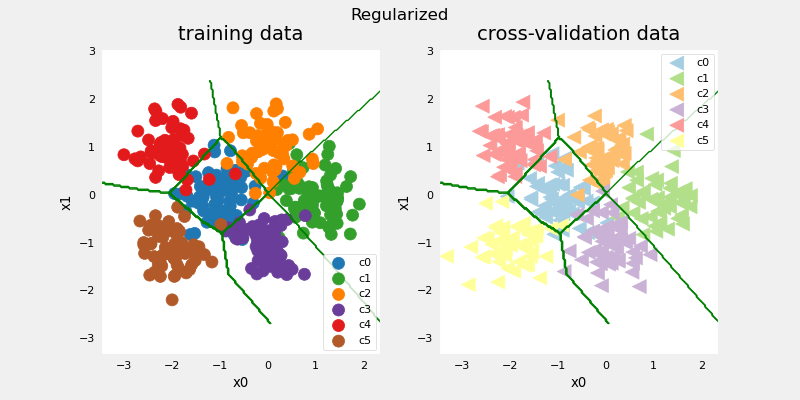

In [62]:
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(), axis=1)
plt_nn(model_predict_r, X_train, y_train, classes, X_cv, y_cv, suptitle="Regularized")

Looking good, close to the 'ideal.' Classification error?

In [63]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))

print("Training:\t", training_cerr_reg)
print("CV:\t\t", cv_cerr_reg)
print("Test:\t\t", test_cerr_reg)

Training:	 0.0625
CV:		 0.065625
Test:		 0.15


In [64]:
# As before, iterate to find optimal regularization value
# Takes a while
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models = [None] * len(lambdas)

for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] = Sequential(
        [
            Dense(120, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
            Dense(40, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
            Dense(classes)
        ]
    )
    models[i].compile(
        loss=SparseCategoricalCrossentropy(from_logits=True),
        optimizer=Adam(learning_rate=0.01)
    )
    models[i].fit(X_train, y_train, epochs=1000)
    print(f"Finished lambda = {lambda_}")

Epoch 1/1000
13/13 [==============================] - 0s 719us/step - loss: 5.8501
Epoch 2/1000
13/13 [==============================] - 0s 651us/step - loss: 1.8165
Epoch 3/1000
13/13 [==============================] - 0s 558us/step - loss: 1.3945
Epoch 4/1000
13/13 [==============================] - 0s 561us/step - loss: 1.1554
Epoch 5/1000
13/13 [==============================] - 0s 547us/step - loss: 1.0094
Epoch 6/1000
13/13 [==============================] - 0s 542us/step - loss: 1.0342
Epoch 7/1000
13/13 [==============================] - 0s 516us/step - loss: 0.9784
Epoch 8/1000
13/13 [==============================] - 0s 674us/step - loss: 0.9150
Epoch 9/1000
13/13 [==============================] - 0s 637us/step - loss: 0.8168
Epoch 10/1000
13/13 [==============================] - 0s 551us/step - loss: 0.7619
Epoch 11/1000
13/13 [==============================] - 0s 619us/step - loss: 0.7462
Epoch 12/1000
13/13 [==============================] - 0s 564us/step - loss: 0.7307
E

13/13 [==============================] - 0s 523us/step - loss: 0.4444
Epoch 99/1000
13/13 [==============================] - 0s 479us/step - loss: 0.4722
Epoch 100/1000
13/13 [==============================] - 0s 475us/step - loss: 0.4915
Epoch 101/1000
13/13 [==============================] - 0s 485us/step - loss: 0.4634
Epoch 102/1000
13/13 [==============================] - 0s 606us/step - loss: 0.4775
Epoch 103/1000
13/13 [==============================] - 0s 438us/step - loss: 0.4391
Epoch 104/1000
13/13 [==============================] - 0s 603us/step - loss: 0.4613
Epoch 105/1000
13/13 [==============================] - 0s 520us/step - loss: 0.4871
Epoch 106/1000
13/13 [==============================] - 0s 576us/step - loss: 0.4650
Epoch 107/1000
13/13 [==============================] - 0s 517us/step - loss: 0.4469
Epoch 108/1000
13/13 [==============================] - 0s 533us/step - loss: 0.4539
Epoch 109/1000
13/13 [==============================] - 0s 508us/step - loss: 0.4

13/13 [==============================] - 0s 496us/step - loss: 0.4031
Epoch 195/1000
13/13 [==============================] - 0s 594us/step - loss: 0.4393
Epoch 196/1000
13/13 [==============================] - 0s 623us/step - loss: 0.4025
Epoch 197/1000
13/13 [==============================] - 0s 668us/step - loss: 0.4071
Epoch 198/1000
13/13 [==============================] - 0s 498us/step - loss: 0.3818
Epoch 199/1000
13/13 [==============================] - 0s 625us/step - loss: 0.4046
Epoch 200/1000
13/13 [==============================] - 0s 508us/step - loss: 0.3933
Epoch 201/1000
13/13 [==============================] - 0s 612us/step - loss: 0.4326
Epoch 202/1000
13/13 [==============================] - 0s 436us/step - loss: 0.4166
Epoch 203/1000
13/13 [==============================] - 0s 564us/step - loss: 0.3744
Epoch 204/1000
13/13 [==============================] - 0s 607us/step - loss: 0.4141
Epoch 205/1000
13/13 [==============================] - 0s 559us/step - loss: 0.

13/13 [==============================] - 0s 605us/step - loss: 0.3883
Epoch 291/1000
13/13 [==============================] - 0s 523us/step - loss: 0.3937
Epoch 292/1000
13/13 [==============================] - 0s 492us/step - loss: 0.4003
Epoch 293/1000
13/13 [==============================] - 0s 588us/step - loss: 0.3670
Epoch 294/1000
13/13 [==============================] - 0s 501us/step - loss: 0.3668
Epoch 295/1000
13/13 [==============================] - 0s 606us/step - loss: 0.4494
Epoch 296/1000
13/13 [==============================] - 0s 451us/step - loss: 0.3535
Epoch 297/1000
13/13 [==============================] - 0s 527us/step - loss: 0.3584
Epoch 298/1000
13/13 [==============================] - 0s 553us/step - loss: 0.3783
Epoch 299/1000
13/13 [==============================] - 0s 686us/step - loss: 0.3726
Epoch 300/1000
13/13 [==============================] - 0s 471us/step - loss: 0.4110
Epoch 301/1000
13/13 [==============================] - 0s 531us/step - loss: 0.

13/13 [==============================] - 0s 596us/step - loss: 0.3569
Epoch 387/1000
13/13 [==============================] - 0s 583us/step - loss: 0.3648
Epoch 388/1000
13/13 [==============================] - 0s 555us/step - loss: 0.3721
Epoch 389/1000
13/13 [==============================] - 0s 550us/step - loss: 0.3395
Epoch 390/1000
13/13 [==============================] - 0s 606us/step - loss: 0.3322
Epoch 391/1000
13/13 [==============================] - 0s 554us/step - loss: 0.3483
Epoch 392/1000
13/13 [==============================] - 0s 661us/step - loss: 0.3831
Epoch 393/1000
13/13 [==============================] - 0s 633us/step - loss: 0.3736
Epoch 394/1000
13/13 [==============================] - 0s 620us/step - loss: 0.3668
Epoch 395/1000
13/13 [==============================] - 0s 588us/step - loss: 0.3830
Epoch 396/1000
13/13 [==============================] - 0s 554us/step - loss: 0.4213
Epoch 397/1000
13/13 [==============================] - 0s 590us/step - loss: 0.

13/13 [==============================] - 0s 485us/step - loss: 0.3853
Epoch 483/1000
13/13 [==============================] - 0s 493us/step - loss: 0.3803
Epoch 484/1000
13/13 [==============================] - 0s 552us/step - loss: 0.3609
Epoch 485/1000
13/13 [==============================] - 0s 625us/step - loss: 0.3804
Epoch 486/1000
13/13 [==============================] - 0s 601us/step - loss: 0.3503
Epoch 487/1000
13/13 [==============================] - 0s 578us/step - loss: 0.3367
Epoch 488/1000
13/13 [==============================] - 0s 576us/step - loss: 0.3382
Epoch 489/1000
13/13 [==============================] - 0s 567us/step - loss: 0.3337
Epoch 490/1000
13/13 [==============================] - 0s 533us/step - loss: 0.3697
Epoch 491/1000
13/13 [==============================] - 0s 627us/step - loss: 0.3834
Epoch 492/1000
13/13 [==============================] - 0s 477us/step - loss: 0.4076
Epoch 493/1000
13/13 [==============================] - 0s 529us/step - loss: 0.

13/13 [==============================] - 0s 508us/step - loss: 0.4526
Epoch 579/1000
13/13 [==============================] - 0s 624us/step - loss: 0.3659
Epoch 580/1000
13/13 [==============================] - 0s 540us/step - loss: 0.3526
Epoch 581/1000
13/13 [==============================] - 0s 535us/step - loss: 0.3726
Epoch 582/1000
13/13 [==============================] - 0s 525us/step - loss: 0.3584
Epoch 583/1000
13/13 [==============================] - 0s 611us/step - loss: 0.3894
Epoch 584/1000
13/13 [==============================] - 0s 539us/step - loss: 0.3719
Epoch 585/1000
13/13 [==============================] - 0s 556us/step - loss: 0.3569
Epoch 586/1000
13/13 [==============================] - 0s 469us/step - loss: 0.3822
Epoch 587/1000
13/13 [==============================] - 0s 587us/step - loss: 0.3739
Epoch 588/1000
13/13 [==============================] - 0s 576us/step - loss: 0.3490
Epoch 589/1000
13/13 [==============================] - 0s 432us/step - loss: 0.

13/13 [==============================] - 0s 601us/step - loss: 0.4088
Epoch 675/1000
13/13 [==============================] - 0s 576us/step - loss: 0.3234
Epoch 676/1000
13/13 [==============================] - 0s 624us/step - loss: 0.3707
Epoch 677/1000
13/13 [==============================] - 0s 684us/step - loss: 0.3159
Epoch 678/1000
13/13 [==============================] - 0s 598us/step - loss: 0.3469
Epoch 679/1000
13/13 [==============================] - 0s 539us/step - loss: 0.3348
Epoch 680/1000
13/13 [==============================] - 0s 514us/step - loss: 0.3315
Epoch 681/1000
13/13 [==============================] - 0s 586us/step - loss: 0.3286
Epoch 682/1000
13/13 [==============================] - 0s 582us/step - loss: 0.3117
Epoch 683/1000
13/13 [==============================] - 0s 644us/step - loss: 0.3030
Epoch 684/1000
13/13 [==============================] - 0s 559us/step - loss: 0.3142
Epoch 685/1000
13/13 [==============================] - 0s 561us/step - loss: 0.

13/13 [==============================] - 0s 525us/step - loss: 0.3148
Epoch 771/1000
13/13 [==============================] - 0s 581us/step - loss: 0.3294
Epoch 772/1000
13/13 [==============================] - 0s 618us/step - loss: 0.3768
Epoch 773/1000
13/13 [==============================] - 0s 579us/step - loss: 0.3632
Epoch 774/1000
13/13 [==============================] - 0s 630us/step - loss: 0.3564
Epoch 775/1000
13/13 [==============================] - 0s 607us/step - loss: 0.3427
Epoch 776/1000
13/13 [==============================] - 0s 615us/step - loss: 0.3977
Epoch 777/1000
13/13 [==============================] - 0s 603us/step - loss: 0.4132
Epoch 778/1000
13/13 [==============================] - 0s 535us/step - loss: 0.3654
Epoch 779/1000
13/13 [==============================] - 0s 518us/step - loss: 0.3112
Epoch 780/1000
13/13 [==============================] - 0s 536us/step - loss: 0.3034
Epoch 781/1000
13/13 [==============================] - 0s 555us/step - loss: 0.

13/13 [==============================] - 0s 689us/step - loss: 0.3383
Epoch 867/1000
13/13 [==============================] - 0s 541us/step - loss: 0.3761
Epoch 868/1000
13/13 [==============================] - 0s 661us/step - loss: 0.3832
Epoch 869/1000
13/13 [==============================] - 0s 559us/step - loss: 0.3542
Epoch 870/1000
13/13 [==============================] - 0s 665us/step - loss: 0.3355
Epoch 871/1000
13/13 [==============================] - 0s 636us/step - loss: 0.3605
Epoch 872/1000
13/13 [==============================] - 0s 608us/step - loss: 0.3691
Epoch 873/1000
13/13 [==============================] - 0s 576us/step - loss: 0.3232
Epoch 874/1000
13/13 [==============================] - 0s 653us/step - loss: 0.3366
Epoch 875/1000
13/13 [==============================] - 0s 610us/step - loss: 0.3184
Epoch 876/1000
13/13 [==============================] - 0s 461us/step - loss: 0.3182
Epoch 877/1000
13/13 [==============================] - 0s 602us/step - loss: 0.

13/13 [==============================] - 0s 450us/step - loss: 0.3052
Epoch 963/1000
13/13 [==============================] - 0s 605us/step - loss: 0.3406
Epoch 964/1000
13/13 [==============================] - 0s 549us/step - loss: 0.2886
Epoch 965/1000
13/13 [==============================] - 0s 500us/step - loss: 0.3341
Epoch 966/1000
13/13 [==============================] - 0s 678us/step - loss: 0.3330
Epoch 967/1000
13/13 [==============================] - 0s 508us/step - loss: 0.3427
Epoch 968/1000
13/13 [==============================] - 0s 651us/step - loss: 0.3067
Epoch 969/1000
13/13 [==============================] - 0s 484us/step - loss: 0.3839
Epoch 970/1000
13/13 [==============================] - 0s 545us/step - loss: 0.3573
Epoch 971/1000
13/13 [==============================] - 0s 495us/step - loss: 0.3166
Epoch 972/1000
13/13 [==============================] - 0s 594us/step - loss: 0.3374
Epoch 973/1000
13/13 [==============================] - 0s 514us/step - loss: 0.

13/13 [==============================] - 0s 520us/step - loss: 0.5145
Epoch 60/1000
13/13 [==============================] - 0s 577us/step - loss: 0.5450
Epoch 61/1000
13/13 [==============================] - 0s 613us/step - loss: 0.5195
Epoch 62/1000
13/13 [==============================] - 0s 493us/step - loss: 0.5324
Epoch 63/1000
13/13 [==============================] - 0s 487us/step - loss: 0.4953
Epoch 64/1000
13/13 [==============================] - 0s 564us/step - loss: 0.4938
Epoch 65/1000
13/13 [==============================] - 0s 618us/step - loss: 0.5240
Epoch 66/1000
13/13 [==============================] - 0s 545us/step - loss: 0.4759
Epoch 67/1000
13/13 [==============================] - 0s 508us/step - loss: 0.4987
Epoch 68/1000
13/13 [==============================] - 0s 601us/step - loss: 0.5189
Epoch 69/1000
13/13 [==============================] - 0s 615us/step - loss: 0.4846
Epoch 70/1000
13/13 [==============================] - 0s 554us/step - loss: 0.4672
Epoch 

13/13 [==============================] - 0s 573us/step - loss: 0.3838
Epoch 157/1000
13/13 [==============================] - 0s 529us/step - loss: 0.4347
Epoch 158/1000
13/13 [==============================] - 0s 471us/step - loss: 0.3839
Epoch 159/1000
13/13 [==============================] - 0s 650us/step - loss: 0.4130
Epoch 160/1000
13/13 [==============================] - 0s 553us/step - loss: 0.4087
Epoch 161/1000
13/13 [==============================] - 0s 547us/step - loss: 0.4241
Epoch 162/1000
13/13 [==============================] - 0s 589us/step - loss: 0.4493
Epoch 163/1000
13/13 [==============================] - 0s 623us/step - loss: 0.3978
Epoch 164/1000
13/13 [==============================] - 0s 617us/step - loss: 0.4290
Epoch 165/1000
13/13 [==============================] - 0s 593us/step - loss: 0.4067
Epoch 166/1000
13/13 [==============================] - 0s 524us/step - loss: 0.4756
Epoch 167/1000
13/13 [==============================] - 0s 605us/step - loss: 0.

13/13 [==============================] - 0s 592us/step - loss: 0.3977
Epoch 253/1000
13/13 [==============================] - 0s 496us/step - loss: 0.3434
Epoch 254/1000
13/13 [==============================] - 0s 602us/step - loss: 0.4217
Epoch 255/1000
13/13 [==============================] - 0s 600us/step - loss: 0.3857
Epoch 256/1000
13/13 [==============================] - 0s 551us/step - loss: 0.4168
Epoch 257/1000
13/13 [==============================] - 0s 517us/step - loss: 0.3732
Epoch 258/1000
13/13 [==============================] - 0s 569us/step - loss: 0.3794
Epoch 259/1000
13/13 [==============================] - 0s 583us/step - loss: 0.3714
Epoch 260/1000
13/13 [==============================] - 0s 510us/step - loss: 0.3746
Epoch 261/1000
13/13 [==============================] - 0s 583us/step - loss: 0.3707
Epoch 262/1000
13/13 [==============================] - 0s 555us/step - loss: 0.4417
Epoch 263/1000
13/13 [==============================] - 0s 459us/step - loss: 0.

13/13 [==============================] - 0s 601us/step - loss: 0.4465
Epoch 349/1000
13/13 [==============================] - 0s 525us/step - loss: 0.4185
Epoch 350/1000
13/13 [==============================] - 0s 543us/step - loss: 0.4491
Epoch 351/1000
13/13 [==============================] - 0s 499us/step - loss: 0.3345
Epoch 352/1000
13/13 [==============================] - 0s 588us/step - loss: 0.3981
Epoch 353/1000
13/13 [==============================] - 0s 599us/step - loss: 0.3724
Epoch 354/1000
13/13 [==============================] - 0s 451us/step - loss: 0.3442
Epoch 355/1000
13/13 [==============================] - 0s 583us/step - loss: 0.3674
Epoch 356/1000
13/13 [==============================] - 0s 574us/step - loss: 0.3592
Epoch 357/1000
13/13 [==============================] - 0s 589us/step - loss: 0.3670
Epoch 358/1000
13/13 [==============================] - 0s 505us/step - loss: 0.3815
Epoch 359/1000
13/13 [==============================] - 0s 645us/step - loss: 0.

13/13 [==============================] - 0s 565us/step - loss: 0.3899
Epoch 445/1000
13/13 [==============================] - 0s 565us/step - loss: 0.3779
Epoch 446/1000
13/13 [==============================] - 0s 622us/step - loss: 0.3574
Epoch 447/1000
13/13 [==============================] - 0s 558us/step - loss: 0.4066
Epoch 448/1000
13/13 [==============================] - 0s 570us/step - loss: 0.3761
Epoch 449/1000
13/13 [==============================] - 0s 623us/step - loss: 0.3513
Epoch 450/1000
13/13 [==============================] - 0s 532us/step - loss: 0.3677
Epoch 451/1000
13/13 [==============================] - 0s 602us/step - loss: 0.3254
Epoch 452/1000
13/13 [==============================] - 0s 618us/step - loss: 0.3427
Epoch 453/1000
13/13 [==============================] - 0s 564us/step - loss: 0.3821
Epoch 454/1000
13/13 [==============================] - 0s 615us/step - loss: 0.3608
Epoch 455/1000
13/13 [==============================] - 0s 542us/step - loss: 0.

13/13 [==============================] - 0s 502us/step - loss: 0.4050
Epoch 541/1000
13/13 [==============================] - 0s 607us/step - loss: 0.4165
Epoch 542/1000
13/13 [==============================] - 0s 514us/step - loss: 0.3923
Epoch 543/1000
13/13 [==============================] - 0s 612us/step - loss: 0.3723
Epoch 544/1000
13/13 [==============================] - 0s 610us/step - loss: 0.3841
Epoch 545/1000
13/13 [==============================] - 0s 602us/step - loss: 0.3600
Epoch 546/1000
13/13 [==============================] - 0s 552us/step - loss: 0.3416
Epoch 547/1000
13/13 [==============================] - 0s 607us/step - loss: 0.4170
Epoch 548/1000
13/13 [==============================] - 0s 464us/step - loss: 0.3561
Epoch 549/1000
13/13 [==============================] - 0s 511us/step - loss: 0.3358
Epoch 550/1000
13/13 [==============================] - 0s 596us/step - loss: 0.3158
Epoch 551/1000
13/13 [==============================] - 0s 615us/step - loss: 0.

13/13 [==============================] - 0s 597us/step - loss: 0.3665
Epoch 637/1000
13/13 [==============================] - 0s 579us/step - loss: 0.3206
Epoch 638/1000
13/13 [==============================] - 0s 550us/step - loss: 0.3431
Epoch 639/1000
13/13 [==============================] - 0s 663us/step - loss: 0.3000
Epoch 640/1000
13/13 [==============================] - 0s 589us/step - loss: 0.3444
Epoch 641/1000
13/13 [==============================] - 0s 557us/step - loss: 0.3321
Epoch 642/1000
13/13 [==============================] - 0s 591us/step - loss: 0.3616
Epoch 643/1000
13/13 [==============================] - 0s 461us/step - loss: 0.3635
Epoch 644/1000
13/13 [==============================] - 0s 644us/step - loss: 0.3454
Epoch 645/1000
13/13 [==============================] - 0s 592us/step - loss: 0.3942
Epoch 646/1000
13/13 [==============================] - 0s 674us/step - loss: 0.3690
Epoch 647/1000
13/13 [==============================] - 0s 513us/step - loss: 0.

13/13 [==============================] - 0s 569us/step - loss: 0.3301
Epoch 733/1000
13/13 [==============================] - 0s 628us/step - loss: 0.3220
Epoch 734/1000
13/13 [==============================] - 0s 470us/step - loss: 0.3543
Epoch 735/1000
13/13 [==============================] - 0s 593us/step - loss: 0.3125
Epoch 736/1000
13/13 [==============================] - 0s 652us/step - loss: 0.3324
Epoch 737/1000
13/13 [==============================] - 0s 597us/step - loss: 0.3847
Epoch 738/1000
13/13 [==============================] - 0s 938us/step - loss: 0.3563
Epoch 739/1000
13/13 [==============================] - 0s 455us/step - loss: 0.3260
Epoch 740/1000
13/13 [==============================] - 0s 431us/step - loss: 0.3430
Epoch 741/1000
13/13 [==============================] - 0s 441us/step - loss: 0.3265
Epoch 742/1000
13/13 [==============================] - 0s 550us/step - loss: 0.3589
Epoch 743/1000
13/13 [==============================] - 0s 447us/step - loss: 0.

13/13 [==============================] - 0s 628us/step - loss: 0.3143
Epoch 829/1000
13/13 [==============================] - 0s 543us/step - loss: 0.3571
Epoch 830/1000
13/13 [==============================] - 0s 625us/step - loss: 0.4255
Epoch 831/1000
13/13 [==============================] - 0s 621us/step - loss: 0.3718
Epoch 832/1000
13/13 [==============================] - 0s 489us/step - loss: 0.3660
Epoch 833/1000
13/13 [==============================] - 0s 575us/step - loss: 0.3224
Epoch 834/1000
13/13 [==============================] - 0s 576us/step - loss: 0.3896
Epoch 835/1000
13/13 [==============================] - 0s 631us/step - loss: 0.3163
Epoch 836/1000
13/13 [==============================] - 0s 511us/step - loss: 0.3415
Epoch 837/1000
13/13 [==============================] - 0s 551us/step - loss: 0.3734
Epoch 838/1000
13/13 [==============================] - 0s 444us/step - loss: 0.3328
Epoch 839/1000
13/13 [==============================] - 0s 609us/step - loss: 0.

13/13 [==============================] - 0s 569us/step - loss: 0.3067
Epoch 925/1000
13/13 [==============================] - 0s 542us/step - loss: 0.3211
Epoch 926/1000
13/13 [==============================] - 0s 555us/step - loss: 0.3083
Epoch 927/1000
13/13 [==============================] - 0s 600us/step - loss: 0.3218
Epoch 928/1000
13/13 [==============================] - 0s 552us/step - loss: 0.3051
Epoch 929/1000
13/13 [==============================] - 0s 609us/step - loss: 0.2931
Epoch 930/1000
13/13 [==============================] - 0s 579us/step - loss: 0.3801
Epoch 931/1000
13/13 [==============================] - 0s 622us/step - loss: 0.4737
Epoch 932/1000
13/13 [==============================] - 0s 573us/step - loss: 0.3858
Epoch 933/1000
13/13 [==============================] - 0s 599us/step - loss: 0.3324
Epoch 934/1000
13/13 [==============================] - 0s 527us/step - loss: 0.3673
Epoch 935/1000
13/13 [==============================] - 0s 494us/step - loss: 0.

13/13 [==============================] - 0s 474us/step - loss: 0.6803
Epoch 21/1000
13/13 [==============================] - 0s 575us/step - loss: 0.6351
Epoch 22/1000
13/13 [==============================] - 0s 582us/step - loss: 0.6567
Epoch 23/1000
13/13 [==============================] - 0s 535us/step - loss: 0.6548
Epoch 24/1000
13/13 [==============================] - 0s 620us/step - loss: 0.6668
Epoch 25/1000
13/13 [==============================] - 0s 514us/step - loss: 0.6416
Epoch 26/1000
13/13 [==============================] - 0s 511us/step - loss: 0.7621
Epoch 27/1000
13/13 [==============================] - 0s 559us/step - loss: 0.6678
Epoch 28/1000
13/13 [==============================] - 0s 617us/step - loss: 0.5991
Epoch 29/1000
13/13 [==============================] - 0s 543us/step - loss: 0.6029
Epoch 30/1000
13/13 [==============================] - 0s 554us/step - loss: 0.6562
Epoch 31/1000
13/13 [==============================] - 0s 621us/step - loss: 0.6396
Epoch 

13/13 [==============================] - 0s 563us/step - loss: 0.4616
Epoch 118/1000
13/13 [==============================] - 0s 548us/step - loss: 0.4541
Epoch 119/1000
13/13 [==============================] - 0s 665us/step - loss: 0.4471
Epoch 120/1000
13/13 [==============================] - 0s 528us/step - loss: 0.4544
Epoch 121/1000
13/13 [==============================] - 0s 630us/step - loss: 0.4977
Epoch 122/1000
13/13 [==============================] - 0s 582us/step - loss: 0.5155
Epoch 123/1000
13/13 [==============================] - 0s 573us/step - loss: 0.4134
Epoch 124/1000
13/13 [==============================] - 0s 542us/step - loss: 0.4357
Epoch 125/1000
13/13 [==============================] - 0s 592us/step - loss: 0.4270
Epoch 126/1000
13/13 [==============================] - 0s 569us/step - loss: 0.4227
Epoch 127/1000
13/13 [==============================] - 0s 509us/step - loss: 0.4185
Epoch 128/1000
13/13 [==============================] - 0s 642us/step - loss: 0.

13/13 [==============================] - 0s 591us/step - loss: 0.4042
Epoch 214/1000
13/13 [==============================] - 0s 547us/step - loss: 0.3999
Epoch 215/1000
13/13 [==============================] - 0s 617us/step - loss: 0.3859
Epoch 216/1000
13/13 [==============================] - 0s 581us/step - loss: 0.4028
Epoch 217/1000
13/13 [==============================] - 0s 638us/step - loss: 0.3781
Epoch 218/1000
13/13 [==============================] - 0s 635us/step - loss: 0.4158
Epoch 219/1000
13/13 [==============================] - 0s 517us/step - loss: 0.3770
Epoch 220/1000
13/13 [==============================] - 0s 469us/step - loss: 0.4124
Epoch 221/1000
13/13 [==============================] - 0s 451us/step - loss: 0.3872
Epoch 222/1000
13/13 [==============================] - 0s 403us/step - loss: 0.4120
Epoch 223/1000
13/13 [==============================] - 0s 422us/step - loss: 0.4342
Epoch 224/1000
13/13 [==============================] - 0s 572us/step - loss: 0.

13/13 [==============================] - 0s 484us/step - loss: 0.3661
Epoch 310/1000
13/13 [==============================] - 0s 515us/step - loss: 0.3911
Epoch 311/1000
13/13 [==============================] - 0s 517us/step - loss: 0.3692
Epoch 312/1000
13/13 [==============================] - 0s 615us/step - loss: 0.3754
Epoch 313/1000
13/13 [==============================] - 0s 466us/step - loss: 0.3650
Epoch 314/1000
13/13 [==============================] - 0s 578us/step - loss: 0.3830
Epoch 315/1000
13/13 [==============================] - 0s 591us/step - loss: 0.3759
Epoch 316/1000
13/13 [==============================] - 0s 585us/step - loss: 0.3505
Epoch 317/1000
13/13 [==============================] - 0s 639us/step - loss: 0.3550
Epoch 318/1000
13/13 [==============================] - 0s 512us/step - loss: 0.3705
Epoch 319/1000
13/13 [==============================] - 0s 559us/step - loss: 0.3659
Epoch 320/1000
13/13 [==============================] - 0s 637us/step - loss: 0.

13/13 [==============================] - 0s 503us/step - loss: 0.3425
Epoch 406/1000
13/13 [==============================] - 0s 449us/step - loss: 0.3319
Epoch 407/1000
13/13 [==============================] - 0s 550us/step - loss: 0.3441
Epoch 408/1000
13/13 [==============================] - 0s 573us/step - loss: 0.3500
Epoch 409/1000
13/13 [==============================] - 0s 581us/step - loss: 0.3600
Epoch 410/1000
13/13 [==============================] - 0s 552us/step - loss: 0.3937
Epoch 411/1000
13/13 [==============================] - 0s 549us/step - loss: 0.4299
Epoch 412/1000
13/13 [==============================] - 0s 471us/step - loss: 0.3975
Epoch 413/1000
13/13 [==============================] - 0s 640us/step - loss: 0.3587
Epoch 414/1000
13/13 [==============================] - 0s 558us/step - loss: 0.3679
Epoch 415/1000
13/13 [==============================] - 0s 558us/step - loss: 0.3579
Epoch 416/1000
13/13 [==============================] - 0s 504us/step - loss: 0.

13/13 [==============================] - 0s 561us/step - loss: 0.3070
Epoch 502/1000
13/13 [==============================] - 0s 456us/step - loss: 0.3238
Epoch 503/1000
13/13 [==============================] - 0s 584us/step - loss: 0.3521
Epoch 504/1000
13/13 [==============================] - 0s 540us/step - loss: 0.3879
Epoch 505/1000
13/13 [==============================] - 0s 625us/step - loss: 0.4163
Epoch 506/1000
13/13 [==============================] - 0s 504us/step - loss: 0.3901
Epoch 507/1000
13/13 [==============================] - 0s 652us/step - loss: 0.3219
Epoch 508/1000
13/13 [==============================] - 0s 429us/step - loss: 0.3234
Epoch 509/1000
13/13 [==============================] - 0s 561us/step - loss: 0.3888
Epoch 510/1000
13/13 [==============================] - 0s 536us/step - loss: 0.3472
Epoch 511/1000
13/13 [==============================] - 0s 609us/step - loss: 0.3316
Epoch 512/1000
13/13 [==============================] - 0s 471us/step - loss: 0.

13/13 [==============================] - 0s 533us/step - loss: 0.3422
Epoch 598/1000
13/13 [==============================] - 0s 573us/step - loss: 0.3424
Epoch 599/1000
13/13 [==============================] - 0s 494us/step - loss: 0.3591
Epoch 600/1000
13/13 [==============================] - 0s 596us/step - loss: 0.3559
Epoch 601/1000
13/13 [==============================] - 0s 570us/step - loss: 0.3297
Epoch 602/1000
13/13 [==============================] - 0s 588us/step - loss: 0.3060
Epoch 603/1000
13/13 [==============================] - 0s 485us/step - loss: 0.3002
Epoch 604/1000
13/13 [==============================] - 0s 547us/step - loss: 0.3763
Epoch 605/1000
13/13 [==============================] - 0s 602us/step - loss: 0.3324
Epoch 606/1000
13/13 [==============================] - 0s 628us/step - loss: 0.3768
Epoch 607/1000
13/13 [==============================] - 0s 505us/step - loss: 0.3514
Epoch 608/1000
13/13 [==============================] - 0s 627us/step - loss: 0.

13/13 [==============================] - 0s 531us/step - loss: 0.3275
Epoch 694/1000
13/13 [==============================] - 0s 561us/step - loss: 0.3308
Epoch 695/1000
13/13 [==============================] - 0s 504us/step - loss: 0.3531
Epoch 696/1000
13/13 [==============================] - 0s 601us/step - loss: 0.3324
Epoch 697/1000
13/13 [==============================] - 0s 567us/step - loss: 0.3170
Epoch 698/1000
13/13 [==============================] - 0s 565us/step - loss: 0.3347
Epoch 699/1000
13/13 [==============================] - 0s 601us/step - loss: 0.3453
Epoch 700/1000
13/13 [==============================] - 0s 641us/step - loss: 0.3572
Epoch 701/1000
13/13 [==============================] - 0s 533us/step - loss: 0.3237
Epoch 702/1000
13/13 [==============================] - 0s 770us/step - loss: 0.3393
Epoch 703/1000
13/13 [==============================] - 0s 553us/step - loss: 0.3382
Epoch 704/1000
13/13 [==============================] - 0s 574us/step - loss: 0.

13/13 [==============================] - 0s 549us/step - loss: 0.2939
Epoch 790/1000
13/13 [==============================] - 0s 559us/step - loss: 0.2951
Epoch 791/1000
13/13 [==============================] - 0s 570us/step - loss: 0.3866
Epoch 792/1000
13/13 [==============================] - 0s 473us/step - loss: 0.4133
Epoch 793/1000
13/13 [==============================] - 0s 611us/step - loss: 0.3365
Epoch 794/1000
13/13 [==============================] - 0s 661us/step - loss: 0.3376
Epoch 795/1000
13/13 [==============================] - 0s 504us/step - loss: 0.3356
Epoch 796/1000
13/13 [==============================] - 0s 576us/step - loss: 0.3538
Epoch 797/1000
13/13 [==============================] - 0s 545us/step - loss: 0.3029
Epoch 798/1000
13/13 [==============================] - 0s 586us/step - loss: 0.3641
Epoch 799/1000
13/13 [==============================] - 0s 597us/step - loss: 0.3741
Epoch 800/1000
13/13 [==============================] - 0s 563us/step - loss: 0.

13/13 [==============================] - 0s 575us/step - loss: 0.3684
Epoch 886/1000
13/13 [==============================] - 0s 508us/step - loss: 0.3576
Epoch 887/1000
13/13 [==============================] - 0s 576us/step - loss: 0.3453
Epoch 888/1000
13/13 [==============================] - 0s 567us/step - loss: 0.3221
Epoch 889/1000
13/13 [==============================] - 0s 658us/step - loss: 0.2979
Epoch 890/1000
13/13 [==============================] - 0s 528us/step - loss: 0.3228
Epoch 891/1000
13/13 [==============================] - 0s 537us/step - loss: 0.3559
Epoch 892/1000
13/13 [==============================] - 0s 514us/step - loss: 0.3094
Epoch 893/1000
13/13 [==============================] - 0s 643us/step - loss: 0.2907
Epoch 894/1000
13/13 [==============================] - 0s 615us/step - loss: 0.3413
Epoch 895/1000
13/13 [==============================] - 0s 641us/step - loss: 0.3709
Epoch 896/1000
13/13 [==============================] - 0s 686us/step - loss: 0.

13/13 [==============================] - 0s 631us/step - loss: 0.3452
Epoch 982/1000
13/13 [==============================] - 0s 607us/step - loss: 0.3449
Epoch 983/1000
13/13 [==============================] - 0s 456us/step - loss: 0.3222
Epoch 984/1000
13/13 [==============================] - 0s 500us/step - loss: 0.3327
Epoch 985/1000
13/13 [==============================] - 0s 589us/step - loss: 0.3540
Epoch 986/1000
13/13 [==============================] - 0s 647us/step - loss: 0.3419
Epoch 987/1000
13/13 [==============================] - 0s 578us/step - loss: 0.3575
Epoch 988/1000
13/13 [==============================] - 0s 600us/step - loss: 0.3053
Epoch 989/1000
13/13 [==============================] - 0s 550us/step - loss: 0.3368
Epoch 990/1000
13/13 [==============================] - 0s 541us/step - loss: 0.3389
Epoch 991/1000
13/13 [==============================] - 0s 593us/step - loss: 0.3757
Epoch 992/1000
13/13 [==============================] - 0s 541us/step - loss: 0.

13/13 [==============================] - 0s 579us/step - loss: 0.5607
Epoch 79/1000
13/13 [==============================] - 0s 465us/step - loss: 0.5424
Epoch 80/1000
13/13 [==============================] - 0s 576us/step - loss: 0.4827
Epoch 81/1000
13/13 [==============================] - 0s 476us/step - loss: 0.5339
Epoch 82/1000
13/13 [==============================] - 0s 590us/step - loss: 0.4997
Epoch 83/1000
13/13 [==============================] - 0s 633us/step - loss: 0.4847
Epoch 84/1000
13/13 [==============================] - 0s 561us/step - loss: 0.4656
Epoch 85/1000
13/13 [==============================] - 0s 585us/step - loss: 0.4731
Epoch 86/1000
13/13 [==============================] - 0s 581us/step - loss: 0.4858
Epoch 87/1000
13/13 [==============================] - 0s 553us/step - loss: 0.4723
Epoch 88/1000
13/13 [==============================] - 0s 612us/step - loss: 0.4945
Epoch 89/1000
13/13 [==============================] - 0s 586us/step - loss: 0.4700
Epoch 

13/13 [==============================] - 0s 584us/step - loss: 0.4226
Epoch 175/1000
13/13 [==============================] - 0s 600us/step - loss: 0.4251
Epoch 176/1000
13/13 [==============================] - 0s 449us/step - loss: 0.4556
Epoch 177/1000
13/13 [==============================] - 0s 480us/step - loss: 0.4756
Epoch 178/1000
13/13 [==============================] - 0s 527us/step - loss: 0.4369
Epoch 179/1000
13/13 [==============================] - 0s 611us/step - loss: 0.4221
Epoch 180/1000
13/13 [==============================] - 0s 620us/step - loss: 0.4244
Epoch 181/1000
13/13 [==============================] - 0s 473us/step - loss: 0.4362
Epoch 182/1000
13/13 [==============================] - 0s 604us/step - loss: 0.4103
Epoch 183/1000
13/13 [==============================] - 0s 645us/step - loss: 0.3870
Epoch 184/1000
13/13 [==============================] - 0s 585us/step - loss: 0.4156
Epoch 185/1000
13/13 [==============================] - 0s 500us/step - loss: 0.

13/13 [==============================] - 0s 595us/step - loss: 0.3818
Epoch 271/1000
13/13 [==============================] - 0s 580us/step - loss: 0.3847
Epoch 272/1000
13/13 [==============================] - 0s 533us/step - loss: 0.3903
Epoch 273/1000
13/13 [==============================] - 0s 532us/step - loss: 0.4410
Epoch 274/1000
13/13 [==============================] - 0s 604us/step - loss: 0.3676
Epoch 275/1000
13/13 [==============================] - 0s 621us/step - loss: 0.3721
Epoch 276/1000
13/13 [==============================] - 0s 616us/step - loss: 0.4017
Epoch 277/1000
13/13 [==============================] - 0s 605us/step - loss: 0.3942
Epoch 278/1000
13/13 [==============================] - 0s 458us/step - loss: 0.4095
Epoch 279/1000
13/13 [==============================] - 0s 597us/step - loss: 0.3780
Epoch 280/1000
13/13 [==============================] - 0s 597us/step - loss: 0.4102
Epoch 281/1000
13/13 [==============================] - 0s 517us/step - loss: 0.

13/13 [==============================] - 0s 558us/step - loss: 0.3676
Epoch 367/1000
13/13 [==============================] - 0s 539us/step - loss: 0.3438
Epoch 368/1000
13/13 [==============================] - 0s 594us/step - loss: 0.4081
Epoch 369/1000
13/13 [==============================] - 0s 586us/step - loss: 0.4176
Epoch 370/1000
13/13 [==============================] - 0s 525us/step - loss: 0.3599
Epoch 371/1000
13/13 [==============================] - 0s 576us/step - loss: 0.3849
Epoch 372/1000
13/13 [==============================] - 0s 520us/step - loss: 0.3734
Epoch 373/1000
13/13 [==============================] - 0s 568us/step - loss: 0.3855
Epoch 374/1000
13/13 [==============================] - 0s 579us/step - loss: 0.3532
Epoch 375/1000
13/13 [==============================] - 0s 507us/step - loss: 0.3498
Epoch 376/1000
13/13 [==============================] - 0s 540us/step - loss: 0.3682
Epoch 377/1000
13/13 [==============================] - 0s 643us/step - loss: 0.

13/13 [==============================] - 0s 576us/step - loss: 0.3337
Epoch 463/1000
13/13 [==============================] - 0s 660us/step - loss: 0.3617
Epoch 464/1000
13/13 [==============================] - 0s 593us/step - loss: 0.3863
Epoch 465/1000
13/13 [==============================] - 0s 652us/step - loss: 0.3284
Epoch 466/1000
13/13 [==============================] - 0s 656us/step - loss: 0.4037
Epoch 467/1000
13/13 [==============================] - 0s 690us/step - loss: 0.3303
Epoch 468/1000
13/13 [==============================] - 0s 579us/step - loss: 0.3527
Epoch 469/1000
13/13 [==============================] - 0s 530us/step - loss: 0.4073
Epoch 470/1000
13/13 [==============================] - 0s 573us/step - loss: 0.3558
Epoch 471/1000
13/13 [==============================] - 0s 504us/step - loss: 0.3391
Epoch 472/1000
13/13 [==============================] - 0s 555us/step - loss: 0.4160
Epoch 473/1000
13/13 [==============================] - 0s 589us/step - loss: 0.

13/13 [==============================] - 0s 575us/step - loss: 0.3770
Epoch 559/1000
13/13 [==============================] - 0s 503us/step - loss: 0.3462
Epoch 560/1000
13/13 [==============================] - 0s 520us/step - loss: 0.3540
Epoch 561/1000
13/13 [==============================] - 0s 602us/step - loss: 0.3307
Epoch 562/1000
13/13 [==============================] - 0s 593us/step - loss: 0.3869
Epoch 563/1000
13/13 [==============================] - 0s 654us/step - loss: 0.3210
Epoch 564/1000
13/13 [==============================] - 0s 617us/step - loss: 0.3441
Epoch 565/1000
13/13 [==============================] - 0s 529us/step - loss: 0.3301
Epoch 566/1000
13/13 [==============================] - 0s 539us/step - loss: 0.3075
Epoch 567/1000
13/13 [==============================] - 0s 574us/step - loss: 0.3233
Epoch 568/1000
13/13 [==============================] - 0s 636us/step - loss: 0.3476
Epoch 569/1000
13/13 [==============================] - 0s 614us/step - loss: 0.

13/13 [==============================] - 0s 615us/step - loss: 0.3309
Epoch 655/1000
13/13 [==============================] - 0s 515us/step - loss: 0.3306
Epoch 656/1000
13/13 [==============================] - 0s 591us/step - loss: 0.3282
Epoch 657/1000
13/13 [==============================] - 0s 588us/step - loss: 0.3226
Epoch 658/1000
13/13 [==============================] - 0s 575us/step - loss: 0.3344
Epoch 659/1000
13/13 [==============================] - 0s 592us/step - loss: 0.3290
Epoch 660/1000
13/13 [==============================] - 0s 562us/step - loss: 0.3844
Epoch 661/1000
13/13 [==============================] - 0s 537us/step - loss: 0.3521
Epoch 662/1000
13/13 [==============================] - 0s 542us/step - loss: 0.3010
Epoch 663/1000
13/13 [==============================] - 0s 559us/step - loss: 0.3537
Epoch 664/1000
13/13 [==============================] - 0s 538us/step - loss: 0.3323
Epoch 665/1000
13/13 [==============================] - 0s 548us/step - loss: 0.

13/13 [==============================] - 0s 580us/step - loss: 0.3054
Epoch 751/1000
13/13 [==============================] - 0s 622us/step - loss: 0.3532
Epoch 752/1000
13/13 [==============================] - 0s 568us/step - loss: 0.3769
Epoch 753/1000
13/13 [==============================] - 0s 560us/step - loss: 0.4420
Epoch 754/1000
13/13 [==============================] - 0s 620us/step - loss: 0.3400
Epoch 755/1000
13/13 [==============================] - 0s 648us/step - loss: 0.3599
Epoch 756/1000
13/13 [==============================] - 0s 677us/step - loss: 0.3538
Epoch 757/1000
13/13 [==============================] - 0s 557us/step - loss: 0.3368
Epoch 758/1000
13/13 [==============================] - 0s 476us/step - loss: 0.3697
Epoch 759/1000
13/13 [==============================] - 0s 527us/step - loss: 0.3400
Epoch 760/1000
13/13 [==============================] - 0s 608us/step - loss: 0.3593
Epoch 761/1000
13/13 [==============================] - 0s 545us/step - loss: 0.

13/13 [==============================] - 0s 523us/step - loss: 0.3203
Epoch 847/1000
13/13 [==============================] - 0s 599us/step - loss: 0.3451
Epoch 848/1000
13/13 [==============================] - 0s 617us/step - loss: 0.3320
Epoch 849/1000
13/13 [==============================] - 0s 611us/step - loss: 0.2907
Epoch 850/1000
13/13 [==============================] - 0s 495us/step - loss: 0.3286
Epoch 851/1000
13/13 [==============================] - 0s 625us/step - loss: 0.3020
Epoch 852/1000
13/13 [==============================] - 0s 603us/step - loss: 0.3461
Epoch 853/1000
13/13 [==============================] - 0s 529us/step - loss: 0.3257
Epoch 854/1000
13/13 [==============================] - 0s 513us/step - loss: 0.3399
Epoch 855/1000
13/13 [==============================] - 0s 574us/step - loss: 0.3467
Epoch 856/1000
13/13 [==============================] - 0s 636us/step - loss: 0.3367
Epoch 857/1000
13/13 [==============================] - 0s 657us/step - loss: 0.

13/13 [==============================] - 0s 576us/step - loss: 0.3632
Epoch 943/1000
13/13 [==============================] - 0s 590us/step - loss: 0.3294
Epoch 944/1000
13/13 [==============================] - 0s 568us/step - loss: 0.3661
Epoch 945/1000
13/13 [==============================] - 0s 604us/step - loss: 0.3365
Epoch 946/1000
13/13 [==============================] - 0s 507us/step - loss: 0.3197
Epoch 947/1000
13/13 [==============================] - 0s 558us/step - loss: 0.2995
Epoch 948/1000
13/13 [==============================] - 0s 561us/step - loss: 0.3293
Epoch 949/1000
13/13 [==============================] - 0s 530us/step - loss: 0.3212
Epoch 950/1000
13/13 [==============================] - 0s 559us/step - loss: 0.3248
Epoch 951/1000
13/13 [==============================] - 0s 566us/step - loss: 0.3224
Epoch 952/1000
13/13 [==============================] - 0s 611us/step - loss: 0.3644
Epoch 953/1000
13/13 [==============================] - 0s 686us/step - loss: 0.

13/13 [==============================] - 0s 548us/step - loss: 0.5562
Epoch 39/1000
13/13 [==============================] - 0s 519us/step - loss: 0.5534
Epoch 40/1000
13/13 [==============================] - 0s 569us/step - loss: 0.5981
Epoch 41/1000
13/13 [==============================] - 0s 656us/step - loss: 0.5643
Epoch 42/1000
13/13 [==============================] - 0s 600us/step - loss: 0.5684
Epoch 43/1000
13/13 [==============================] - 0s 707us/step - loss: 0.5566
Epoch 44/1000
13/13 [==============================] - 0s 548us/step - loss: 0.5697
Epoch 45/1000
13/13 [==============================] - 0s 666us/step - loss: 0.6227
Epoch 46/1000
13/13 [==============================] - 0s 585us/step - loss: 0.5869
Epoch 47/1000
13/13 [==============================] - 0s 672us/step - loss: 0.5476
Epoch 48/1000
13/13 [==============================] - 0s 577us/step - loss: 0.5597
Epoch 49/1000
13/13 [==============================] - 0s 582us/step - loss: 0.5465
Epoch 

13/13 [==============================] - 0s 600us/step - loss: 0.4492
Epoch 136/1000
13/13 [==============================] - 0s 631us/step - loss: 0.4154
Epoch 137/1000
13/13 [==============================] - 0s 624us/step - loss: 0.4394
Epoch 138/1000
13/13 [==============================] - 0s 592us/step - loss: 0.4564
Epoch 139/1000
13/13 [==============================] - 0s 563us/step - loss: 0.4277
Epoch 140/1000
13/13 [==============================] - 0s 617us/step - loss: 0.4177
Epoch 141/1000
13/13 [==============================] - 0s 603us/step - loss: 0.4369
Epoch 142/1000
13/13 [==============================] - 0s 572us/step - loss: 0.4347
Epoch 143/1000
13/13 [==============================] - 0s 568us/step - loss: 0.4406
Epoch 144/1000
13/13 [==============================] - 0s 546us/step - loss: 0.4797
Epoch 145/1000
13/13 [==============================] - 0s 656us/step - loss: 0.4359
Epoch 146/1000
13/13 [==============================] - 0s 470us/step - loss: 0.

13/13 [==============================] - 0s 579us/step - loss: 0.3939
Epoch 232/1000
13/13 [==============================] - 0s 541us/step - loss: 0.4191
Epoch 233/1000
13/13 [==============================] - 0s 633us/step - loss: 0.4128
Epoch 234/1000
13/13 [==============================] - 0s 564us/step - loss: 0.4091
Epoch 235/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3676
Epoch 236/1000
13/13 [==============================] - 0s 534us/step - loss: 0.3987
Epoch 237/1000
13/13 [==============================] - 0s 579us/step - loss: 0.3896
Epoch 238/1000
13/13 [==============================] - 0s 574us/step - loss: 0.4006
Epoch 239/1000
13/13 [==============================] - 0s 591us/step - loss: 0.3889
Epoch 240/1000
13/13 [==============================] - 0s 646us/step - loss: 0.4018
Epoch 241/1000
13/13 [==============================] - 0s 495us/step - loss: 0.4084
Epoch 242/1000
13/13 [==============================] - 0s 503us/step - loss: 0.

13/13 [==============================] - 0s 566us/step - loss: 0.3476
Epoch 328/1000
13/13 [==============================] - 0s 513us/step - loss: 0.3860
Epoch 329/1000
13/13 [==============================] - 0s 536us/step - loss: 0.3968
Epoch 330/1000
13/13 [==============================] - 0s 596us/step - loss: 0.3723
Epoch 331/1000
13/13 [==============================] - 0s 596us/step - loss: 0.3873
Epoch 332/1000
13/13 [==============================] - 0s 644us/step - loss: 0.3552
Epoch 333/1000
13/13 [==============================] - 0s 462us/step - loss: 0.4448
Epoch 334/1000
13/13 [==============================] - 0s 607us/step - loss: 0.3794
Epoch 335/1000
13/13 [==============================] - 0s 536us/step - loss: 0.4047
Epoch 336/1000
13/13 [==============================] - 0s 567us/step - loss: 0.4000
Epoch 337/1000
13/13 [==============================] - 0s 575us/step - loss: 0.4317
Epoch 338/1000
13/13 [==============================] - 0s 548us/step - loss: 0.

13/13 [==============================] - 0s 602us/step - loss: 0.4000
Epoch 424/1000
13/13 [==============================] - 0s 619us/step - loss: 0.3723
Epoch 425/1000
13/13 [==============================] - 0s 555us/step - loss: 0.3383
Epoch 426/1000
13/13 [==============================] - 0s 569us/step - loss: 0.3536
Epoch 427/1000
13/13 [==============================] - 0s 527us/step - loss: 0.3666
Epoch 428/1000
13/13 [==============================] - 0s 581us/step - loss: 0.3300
Epoch 429/1000
13/13 [==============================] - 0s 578us/step - loss: 0.3635
Epoch 430/1000
13/13 [==============================] - 0s 572us/step - loss: 0.3330
Epoch 431/1000
13/13 [==============================] - 0s 543us/step - loss: 0.3565
Epoch 432/1000
13/13 [==============================] - 0s 505us/step - loss: 0.3145
Epoch 433/1000
13/13 [==============================] - 0s 505us/step - loss: 0.3516
Epoch 434/1000
13/13 [==============================] - 0s 600us/step - loss: 0.

13/13 [==============================] - 0s 583us/step - loss: 0.3366
Epoch 520/1000
13/13 [==============================] - 0s 586us/step - loss: 0.3809
Epoch 521/1000
13/13 [==============================] - 0s 612us/step - loss: 0.3433
Epoch 522/1000
13/13 [==============================] - 0s 552us/step - loss: 0.3628
Epoch 523/1000
13/13 [==============================] - 0s 587us/step - loss: 0.4028
Epoch 524/1000
13/13 [==============================] - 0s 630us/step - loss: 0.3375
Epoch 525/1000
13/13 [==============================] - 0s 613us/step - loss: 0.3350
Epoch 526/1000
13/13 [==============================] - 0s 560us/step - loss: 0.3580
Epoch 527/1000
13/13 [==============================] - 0s 610us/step - loss: 0.3544
Epoch 528/1000
13/13 [==============================] - 0s 539us/step - loss: 0.3483
Epoch 529/1000
13/13 [==============================] - 0s 517us/step - loss: 0.3302
Epoch 530/1000
13/13 [==============================] - 0s 643us/step - loss: 0.

13/13 [==============================] - 0s 604us/step - loss: 0.3366
Epoch 616/1000
13/13 [==============================] - 0s 534us/step - loss: 0.3312
Epoch 617/1000
13/13 [==============================] - 0s 577us/step - loss: 0.3284
Epoch 618/1000
13/13 [==============================] - 0s 644us/step - loss: 0.3405
Epoch 619/1000
13/13 [==============================] - 0s 646us/step - loss: 0.3889
Epoch 620/1000
13/13 [==============================] - 0s 563us/step - loss: 0.3667
Epoch 621/1000
13/13 [==============================] - 0s 530us/step - loss: 0.3803
Epoch 622/1000
13/13 [==============================] - 0s 565us/step - loss: 0.3896
Epoch 623/1000
13/13 [==============================] - 0s 583us/step - loss: 0.3267
Epoch 624/1000
13/13 [==============================] - 0s 639us/step - loss: 0.3491
Epoch 625/1000
13/13 [==============================] - 0s 590us/step - loss: 0.3381
Epoch 626/1000
13/13 [==============================] - 0s 553us/step - loss: 0.

13/13 [==============================] - 0s 566us/step - loss: 0.3023
Epoch 712/1000
13/13 [==============================] - 0s 576us/step - loss: 0.3462
Epoch 713/1000
13/13 [==============================] - 0s 555us/step - loss: 0.3955
Epoch 714/1000
13/13 [==============================] - 0s 521us/step - loss: 0.3250
Epoch 715/1000
13/13 [==============================] - 0s 611us/step - loss: 0.3193
Epoch 716/1000
13/13 [==============================] - 0s 536us/step - loss: 0.2985
Epoch 717/1000
13/13 [==============================] - 0s 650us/step - loss: 0.3481
Epoch 718/1000
13/13 [==============================] - 0s 633us/step - loss: 0.3582
Epoch 719/1000
13/13 [==============================] - 0s 618us/step - loss: 0.3872
Epoch 720/1000
13/13 [==============================] - 0s 527us/step - loss: 0.3719
Epoch 721/1000
13/13 [==============================] - 0s 567us/step - loss: 0.3224
Epoch 722/1000
13/13 [==============================] - 0s 547us/step - loss: 0.

13/13 [==============================] - 0s 517us/step - loss: 0.3000
Epoch 808/1000
13/13 [==============================] - 0s 551us/step - loss: 0.3355
Epoch 809/1000
13/13 [==============================] - 0s 545us/step - loss: 0.3759
Epoch 810/1000
13/13 [==============================] - 0s 562us/step - loss: 0.3570
Epoch 811/1000
13/13 [==============================] - 0s 536us/step - loss: 0.3238
Epoch 812/1000
13/13 [==============================] - 0s 585us/step - loss: 0.3070
Epoch 813/1000
13/13 [==============================] - 0s 490us/step - loss: 0.3239
Epoch 814/1000
13/13 [==============================] - 0s 616us/step - loss: 0.2980
Epoch 815/1000
13/13 [==============================] - 0s 552us/step - loss: 0.3273
Epoch 816/1000
13/13 [==============================] - 0s 624us/step - loss: 0.3420
Epoch 817/1000
13/13 [==============================] - 0s 534us/step - loss: 0.3456
Epoch 818/1000
13/13 [==============================] - 0s 568us/step - loss: 0.

13/13 [==============================] - 0s 562us/step - loss: 0.3433
Epoch 904/1000
13/13 [==============================] - 0s 535us/step - loss: 0.3608
Epoch 905/1000
13/13 [==============================] - 0s 557us/step - loss: 0.3092
Epoch 906/1000
13/13 [==============================] - 0s 573us/step - loss: 0.3310
Epoch 907/1000
13/13 [==============================] - 0s 584us/step - loss: 0.2997
Epoch 908/1000
13/13 [==============================] - 0s 511us/step - loss: 0.3350
Epoch 909/1000
13/13 [==============================] - 0s 597us/step - loss: 0.3517
Epoch 910/1000
13/13 [==============================] - 0s 582us/step - loss: 0.3611
Epoch 911/1000
13/13 [==============================] - 0s 635us/step - loss: 0.3189
Epoch 912/1000
13/13 [==============================] - 0s 584us/step - loss: 0.3565
Epoch 913/1000
13/13 [==============================] - 0s 515us/step - loss: 0.3344
Epoch 914/1000
13/13 [==============================] - 0s 533us/step - loss: 0.

13/13 [==============================] - 0s 693us/step - loss: 0.3339
Epoch 1000/1000
13/13 [==============================] - 0s 546us/step - loss: 0.3579
Finished lambda = 0.1
Epoch 1/1000
13/13 [==============================] - 0s 611us/step - loss: 5.9251
Epoch 2/1000
13/13 [==============================] - 0s 554us/step - loss: 1.7575
Epoch 3/1000
13/13 [==============================] - 0s 582us/step - loss: 1.3230
Epoch 4/1000
13/13 [==============================] - 0s 534us/step - loss: 1.1031
Epoch 5/1000
13/13 [==============================] - 0s 623us/step - loss: 0.9475
Epoch 6/1000
13/13 [==============================] - 0s 592us/step - loss: 1.0061
Epoch 7/1000
13/13 [==============================] - 0s 525us/step - loss: 0.9396
Epoch 8/1000
13/13 [==============================] - 0s 544us/step - loss: 0.8907
Epoch 9/1000
13/13 [==============================] - 0s 618us/step - loss: 0.8014
Epoch 10/1000
13/13 [==============================] - 0s 619us/step - loss

13/13 [==============================] - 0s 565us/step - loss: 0.4451
Epoch 97/1000
13/13 [==============================] - 0s 573us/step - loss: 0.4527
Epoch 98/1000
13/13 [==============================] - 0s 552us/step - loss: 0.4520
Epoch 99/1000
13/13 [==============================] - 0s 524us/step - loss: 0.4976
Epoch 100/1000
13/13 [==============================] - 0s 564us/step - loss: 0.5175
Epoch 101/1000
13/13 [==============================] - 0s 514us/step - loss: 0.4806
Epoch 102/1000
13/13 [==============================] - 0s 536us/step - loss: 0.4850
Epoch 103/1000
13/13 [==============================] - 0s 559us/step - loss: 0.4401
Epoch 104/1000
13/13 [==============================] - 0s 551us/step - loss: 0.4621
Epoch 105/1000
13/13 [==============================] - 0s 577us/step - loss: 0.4839
Epoch 106/1000
13/13 [==============================] - 0s 534us/step - loss: 0.5033
Epoch 107/1000
13/13 [==============================] - 0s 542us/step - loss: 0.455

13/13 [==============================] - 0s 533us/step - loss: 0.4011
Epoch 193/1000
13/13 [==============================] - 0s 653us/step - loss: 0.3955
Epoch 194/1000
13/13 [==============================] - 0s 508us/step - loss: 0.3980
Epoch 195/1000
13/13 [==============================] - 0s 533us/step - loss: 0.4336
Epoch 196/1000
13/13 [==============================] - 0s 587us/step - loss: 0.4060
Epoch 197/1000
13/13 [==============================] - 0s 577us/step - loss: 0.4068
Epoch 198/1000
13/13 [==============================] - 0s 567us/step - loss: 0.3890
Epoch 199/1000
13/13 [==============================] - 0s 647us/step - loss: 0.4025
Epoch 200/1000
13/13 [==============================] - 0s 489us/step - loss: 0.4026
Epoch 201/1000
13/13 [==============================] - 0s 566us/step - loss: 0.4240
Epoch 202/1000
13/13 [==============================] - 0s 595us/step - loss: 0.4114
Epoch 203/1000
13/13 [==============================] - 0s 592us/step - loss: 0.

13/13 [==============================] - 0s 581us/step - loss: 0.3716
Epoch 289/1000
13/13 [==============================] - 0s 561us/step - loss: 0.3690
Epoch 290/1000
13/13 [==============================] - 0s 569us/step - loss: 0.3854
Epoch 291/1000
13/13 [==============================] - 0s 577us/step - loss: 0.3937
Epoch 292/1000
13/13 [==============================] - 0s 686us/step - loss: 0.3989
Epoch 293/1000
13/13 [==============================] - 0s 527us/step - loss: 0.3698
Epoch 294/1000
13/13 [==============================] - 0s 578us/step - loss: 0.3594
Epoch 295/1000
13/13 [==============================] - 0s 464us/step - loss: 0.4688
Epoch 296/1000
13/13 [==============================] - 0s 645us/step - loss: 0.3693
Epoch 297/1000
13/13 [==============================] - 0s 523us/step - loss: 0.3633
Epoch 298/1000
13/13 [==============================] - 0s 601us/step - loss: 0.3972
Epoch 299/1000
13/13 [==============================] - 0s 570us/step - loss: 0.

13/13 [==============================] - 0s 566us/step - loss: 0.3728
Epoch 385/1000
13/13 [==============================] - 0s 602us/step - loss: 0.3795
Epoch 386/1000
13/13 [==============================] - 0s 597us/step - loss: 0.3563
Epoch 387/1000
13/13 [==============================] - 0s 668us/step - loss: 0.3662
Epoch 388/1000
13/13 [==============================] - 0s 615us/step - loss: 0.3786
Epoch 389/1000
13/13 [==============================] - 0s 484us/step - loss: 0.3397
Epoch 390/1000
13/13 [==============================] - 0s 526us/step - loss: 0.3297
Epoch 391/1000
13/13 [==============================] - 0s 642us/step - loss: 0.3495
Epoch 392/1000
13/13 [==============================] - 0s 575us/step - loss: 0.3880
Epoch 393/1000
13/13 [==============================] - 0s 488us/step - loss: 0.3766
Epoch 394/1000
13/13 [==============================] - 0s 601us/step - loss: 0.3720
Epoch 395/1000
13/13 [==============================] - 0s 524us/step - loss: 0.

13/13 [==============================] - 0s 447us/step - loss: 0.3520
Epoch 481/1000
13/13 [==============================] - 0s 647us/step - loss: 0.3750
Epoch 482/1000
13/13 [==============================] - 0s 523us/step - loss: 0.3825
Epoch 483/1000
13/13 [==============================] - 0s 587us/step - loss: 0.3813
Epoch 484/1000
13/13 [==============================] - 0s 434us/step - loss: 0.3545
Epoch 485/1000
13/13 [==============================] - 0s 640us/step - loss: 0.3816
Epoch 486/1000
13/13 [==============================] - 0s 475us/step - loss: 0.3472
Epoch 487/1000
13/13 [==============================] - 0s 601us/step - loss: 0.3278
Epoch 488/1000
13/13 [==============================] - 0s 507us/step - loss: 0.3368
Epoch 489/1000
13/13 [==============================] - 0s 593us/step - loss: 0.3321
Epoch 490/1000
13/13 [==============================] - 0s 613us/step - loss: 0.3663
Epoch 491/1000
13/13 [==============================] - 0s 541us/step - loss: 0.

13/13 [==============================] - 0s 584us/step - loss: 0.3920
Epoch 577/1000
13/13 [==============================] - 0s 572us/step - loss: 0.3570
Epoch 578/1000
13/13 [==============================] - 0s 604us/step - loss: 0.4468
Epoch 579/1000
13/13 [==============================] - 0s 550us/step - loss: 0.3719
Epoch 580/1000
13/13 [==============================] - 0s 565us/step - loss: 0.3480
Epoch 581/1000
13/13 [==============================] - 0s 512us/step - loss: 0.3661
Epoch 582/1000
13/13 [==============================] - 0s 513us/step - loss: 0.3555
Epoch 583/1000
13/13 [==============================] - 0s 556us/step - loss: 0.3885
Epoch 584/1000
13/13 [==============================] - 0s 628us/step - loss: 0.3640
Epoch 585/1000
13/13 [==============================] - 0s 595us/step - loss: 0.3439
Epoch 586/1000
13/13 [==============================] - 0s 629us/step - loss: 0.3627
Epoch 587/1000
13/13 [==============================] - 0s 487us/step - loss: 0.

13/13 [==============================] - 0s 627us/step - loss: 0.3690
Epoch 673/1000
13/13 [==============================] - 0s 578us/step - loss: 0.3760
Epoch 674/1000
13/13 [==============================] - 0s 642us/step - loss: 0.4186
Epoch 675/1000
13/13 [==============================] - 0s 464us/step - loss: 0.3373
Epoch 676/1000
13/13 [==============================] - 0s 613us/step - loss: 0.3635
Epoch 677/1000
13/13 [==============================] - 0s 568us/step - loss: 0.3098
Epoch 678/1000
13/13 [==============================] - 0s 653us/step - loss: 0.3325
Epoch 679/1000
13/13 [==============================] - 0s 565us/step - loss: 0.3198
Epoch 680/1000
13/13 [==============================] - 0s 583us/step - loss: 0.3223
Epoch 681/1000
13/13 [==============================] - 0s 550us/step - loss: 0.3239
Epoch 682/1000
13/13 [==============================] - 0s 542us/step - loss: 0.3066
Epoch 683/1000
13/13 [==============================] - 0s 521us/step - loss: 0.

13/13 [==============================] - 0s 644us/step - loss: 0.3461
Epoch 769/1000
13/13 [==============================] - 0s 462us/step - loss: 0.3450
Epoch 770/1000
13/13 [==============================] - 0s 511us/step - loss: 0.3018
Epoch 771/1000
13/13 [==============================] - 0s 556us/step - loss: 0.3186
Epoch 772/1000
13/13 [==============================] - 0s 588us/step - loss: 0.3709
Epoch 773/1000
13/13 [==============================] - 0s 609us/step - loss: 0.3492
Epoch 774/1000
13/13 [==============================] - 0s 538us/step - loss: 0.3550
Epoch 775/1000
13/13 [==============================] - 0s 593us/step - loss: 0.3448
Epoch 776/1000
13/13 [==============================] - 0s 557us/step - loss: 0.3657
Epoch 777/1000
13/13 [==============================] - 0s 519us/step - loss: 0.3920
Epoch 778/1000
13/13 [==============================] - 0s 610us/step - loss: 0.3640
Epoch 779/1000
13/13 [==============================] - 0s 528us/step - loss: 0.

13/13 [==============================] - 0s 533us/step - loss: 0.3290
Epoch 865/1000
13/13 [==============================] - 0s 585us/step - loss: 0.4144
Epoch 866/1000
13/13 [==============================] - 0s 631us/step - loss: 0.3396
Epoch 867/1000
13/13 [==============================] - 0s 599us/step - loss: 0.3689
Epoch 868/1000
13/13 [==============================] - 0s 617us/step - loss: 0.3803
Epoch 869/1000
13/13 [==============================] - 0s 604us/step - loss: 0.3479
Epoch 870/1000
13/13 [==============================] - 0s 628us/step - loss: 0.3275
Epoch 871/1000
13/13 [==============================] - 0s 548us/step - loss: 0.3668
Epoch 872/1000
13/13 [==============================] - 0s 458us/step - loss: 0.3678
Epoch 873/1000
13/13 [==============================] - 0s 630us/step - loss: 0.3171
Epoch 874/1000
13/13 [==============================] - 0s 551us/step - loss: 0.3255
Epoch 875/1000
13/13 [==============================] - 0s 615us/step - loss: 0.

13/13 [==============================] - 0s 548us/step - loss: 0.3048
Epoch 961/1000
13/13 [==============================] - 0s 625us/step - loss: 0.3274
Epoch 962/1000
13/13 [==============================] - 0s 560us/step - loss: 0.2956
Epoch 963/1000
13/13 [==============================] - 0s 530us/step - loss: 0.3386
Epoch 964/1000
13/13 [==============================] - 0s 551us/step - loss: 0.3145
Epoch 965/1000
13/13 [==============================] - 0s 599us/step - loss: 0.3606
Epoch 966/1000
13/13 [==============================] - 0s 584us/step - loss: 0.3304
Epoch 967/1000
13/13 [==============================] - 0s 551us/step - loss: 0.3464
Epoch 968/1000
13/13 [==============================] - 0s 548us/step - loss: 0.3201
Epoch 969/1000
13/13 [==============================] - 0s 541us/step - loss: 0.3958
Epoch 970/1000
13/13 [==============================] - 0s 500us/step - loss: 0.3573
Epoch 971/1000
13/13 [==============================] - 0s 580us/step - loss: 0.

13/13 [==============================] - 0s 605us/step - loss: 0.5277
Epoch 58/1000
13/13 [==============================] - 0s 543us/step - loss: 0.4771
Epoch 59/1000
13/13 [==============================] - 0s 563us/step - loss: 0.5150
Epoch 60/1000
13/13 [==============================] - 0s 622us/step - loss: 0.5409
Epoch 61/1000
13/13 [==============================] - 0s 566us/step - loss: 0.5296
Epoch 62/1000
13/13 [==============================] - 0s 636us/step - loss: 0.5562
Epoch 63/1000
13/13 [==============================] - 0s 592us/step - loss: 0.5095
Epoch 64/1000
13/13 [==============================] - 0s 618us/step - loss: 0.4897
Epoch 65/1000
13/13 [==============================] - 0s 563us/step - loss: 0.5248
Epoch 66/1000
13/13 [==============================] - 0s 590us/step - loss: 0.4782
Epoch 67/1000
13/13 [==============================] - 0s 517us/step - loss: 0.4986
Epoch 68/1000
13/13 [==============================] - 0s 595us/step - loss: 0.5173
Epoch 

13/13 [==============================] - 0s 605us/step - loss: 0.4258
Epoch 155/1000
13/13 [==============================] - 0s 634us/step - loss: 0.4303
Epoch 156/1000
13/13 [==============================] - 0s 572us/step - loss: 0.3916
Epoch 157/1000
13/13 [==============================] - 0s 687us/step - loss: 0.4415
Epoch 158/1000
13/13 [==============================] - 0s 594us/step - loss: 0.3883
Epoch 159/1000
13/13 [==============================] - 0s 529us/step - loss: 0.4225
Epoch 160/1000
13/13 [==============================] - 0s 556us/step - loss: 0.4179
Epoch 161/1000
13/13 [==============================] - 0s 517us/step - loss: 0.4363
Epoch 162/1000
13/13 [==============================] - 0s 565us/step - loss: 0.4693
Epoch 163/1000
13/13 [==============================] - 0s 624us/step - loss: 0.4048
Epoch 164/1000
13/13 [==============================] - 0s 503us/step - loss: 0.4371
Epoch 165/1000
13/13 [==============================] - 0s 620us/step - loss: 0.

13/13 [==============================] - 0s 586us/step - loss: 0.4215
Epoch 251/1000
13/13 [==============================] - 0s 552us/step - loss: 0.4270
Epoch 252/1000
13/13 [==============================] - 0s 595us/step - loss: 0.4170
Epoch 253/1000
13/13 [==============================] - 0s 529us/step - loss: 0.3543
Epoch 254/1000
13/13 [==============================] - 0s 609us/step - loss: 0.4348
Epoch 255/1000
13/13 [==============================] - 0s 466us/step - loss: 0.4006
Epoch 256/1000
13/13 [==============================] - 0s 520us/step - loss: 0.4241
Epoch 257/1000
13/13 [==============================] - 0s 545us/step - loss: 0.3805
Epoch 258/1000
13/13 [==============================] - 0s 498us/step - loss: 0.3831
Epoch 259/1000
13/13 [==============================] - 0s 597us/step - loss: 0.3793
Epoch 260/1000
13/13 [==============================] - 0s 547us/step - loss: 0.3872
Epoch 261/1000
13/13 [==============================] - 0s 574us/step - loss: 0.

13/13 [==============================] - 0s 566us/step - loss: 0.3701
Epoch 347/1000
13/13 [==============================] - 0s 620us/step - loss: 0.4024
Epoch 348/1000
13/13 [==============================] - 0s 610us/step - loss: 0.4428
Epoch 349/1000
13/13 [==============================] - 0s 571us/step - loss: 0.4221
Epoch 350/1000
13/13 [==============================] - 0s 555us/step - loss: 0.4522
Epoch 351/1000
13/13 [==============================] - 0s 589us/step - loss: 0.3418
Epoch 352/1000
13/13 [==============================] - 0s 523us/step - loss: 0.4072
Epoch 353/1000
13/13 [==============================] - 0s 590us/step - loss: 0.3799
Epoch 354/1000
13/13 [==============================] - 0s 570us/step - loss: 0.3487
Epoch 355/1000
13/13 [==============================] - 0s 628us/step - loss: 0.3701
Epoch 356/1000
13/13 [==============================] - 0s 540us/step - loss: 0.3672
Epoch 357/1000
13/13 [==============================] - 0s 651us/step - loss: 0.

13/13 [==============================] - 0s 567us/step - loss: 0.3552
Epoch 443/1000
13/13 [==============================] - 0s 664us/step - loss: 0.4117
Epoch 444/1000
13/13 [==============================] - 0s 535us/step - loss: 0.3936
Epoch 445/1000
13/13 [==============================] - 0s 569us/step - loss: 0.3893
Epoch 446/1000
13/13 [==============================] - 0s 626us/step - loss: 0.3567
Epoch 447/1000
13/13 [==============================] - 0s 663us/step - loss: 0.3977
Epoch 448/1000
13/13 [==============================] - 0s 522us/step - loss: 0.3734
Epoch 449/1000
13/13 [==============================] - 0s 613us/step - loss: 0.3513
Epoch 450/1000
13/13 [==============================] - 0s 495us/step - loss: 0.3704
Epoch 451/1000
13/13 [==============================] - 0s 522us/step - loss: 0.3304
Epoch 452/1000
13/13 [==============================] - 0s 540us/step - loss: 0.3441
Epoch 453/1000
13/13 [==============================] - 0s 591us/step - loss: 0.

13/13 [==============================] - 0s 473us/step - loss: 0.3523
Epoch 539/1000
13/13 [==============================] - 0s 538us/step - loss: 0.3627
Epoch 540/1000
13/13 [==============================] - 0s 506us/step - loss: 0.4010
Epoch 541/1000
13/13 [==============================] - 0s 543us/step - loss: 0.4029
Epoch 542/1000
13/13 [==============================] - 0s 590us/step - loss: 0.4059
Epoch 543/1000
13/13 [==============================] - 0s 596us/step - loss: 0.3744
Epoch 544/1000
13/13 [==============================] - 0s 626us/step - loss: 0.3838
Epoch 545/1000
13/13 [==============================] - 0s 589us/step - loss: 0.3614
Epoch 546/1000
13/13 [==============================] - 0s 463us/step - loss: 0.3439
Epoch 547/1000
13/13 [==============================] - 0s 552us/step - loss: 0.4244
Epoch 548/1000
13/13 [==============================] - 0s 665us/step - loss: 0.3582
Epoch 549/1000
13/13 [==============================] - 0s 616us/step - loss: 0.

13/13 [==============================] - 0s 590us/step - loss: 0.3749
Epoch 635/1000
13/13 [==============================] - 0s 643us/step - loss: 0.3390
Epoch 636/1000
13/13 [==============================] - 0s 596us/step - loss: 0.3974
Epoch 637/1000
13/13 [==============================] - 0s 555us/step - loss: 0.3079
Epoch 638/1000
13/13 [==============================] - 0s 549us/step - loss: 0.3420
Epoch 639/1000
13/13 [==============================] - 0s 579us/step - loss: 0.3054
Epoch 640/1000
13/13 [==============================] - 0s 582us/step - loss: 0.3663
Epoch 641/1000
13/13 [==============================] - 0s 639us/step - loss: 0.3418
Epoch 642/1000
13/13 [==============================] - 0s 566us/step - loss: 0.3653
Epoch 643/1000
13/13 [==============================] - 0s 527us/step - loss: 0.3648
Epoch 644/1000
13/13 [==============================] - 0s 584us/step - loss: 0.3546
Epoch 645/1000
13/13 [==============================] - 0s 651us/step - loss: 0.

13/13 [==============================] - 0s 552us/step - loss: 0.3135
Epoch 731/1000
13/13 [==============================] - 0s 533us/step - loss: 0.3478
Epoch 732/1000
13/13 [==============================] - 0s 596us/step - loss: 0.3244
Epoch 733/1000
13/13 [==============================] - 0s 515us/step - loss: 0.3269
Epoch 734/1000
13/13 [==============================] - 0s 599us/step - loss: 0.3447
Epoch 735/1000
13/13 [==============================] - 0s 520us/step - loss: 0.3270
Epoch 736/1000
13/13 [==============================] - 0s 586us/step - loss: 0.3342
Epoch 737/1000
13/13 [==============================] - 0s 598us/step - loss: 0.3815
Epoch 738/1000
13/13 [==============================] - 0s 559us/step - loss: 0.3460
Epoch 739/1000
13/13 [==============================] - 0s 560us/step - loss: 0.3201
Epoch 740/1000
13/13 [==============================] - 0s 600us/step - loss: 0.3232
Epoch 741/1000
13/13 [==============================] - 0s 559us/step - loss: 0.

13/13 [==============================] - 0s 670us/step - loss: 0.3648
Epoch 827/1000
13/13 [==============================] - 0s 658us/step - loss: 0.3363
Epoch 828/1000
13/13 [==============================] - 0s 582us/step - loss: 0.3231
Epoch 829/1000
13/13 [==============================] - 0s 611us/step - loss: 0.3587
Epoch 830/1000
13/13 [==============================] - 0s 637us/step - loss: 0.4277
Epoch 831/1000
13/13 [==============================] - 0s 636us/step - loss: 0.3633
Epoch 832/1000
13/13 [==============================] - 0s 506us/step - loss: 0.3766
Epoch 833/1000
13/13 [==============================] - 0s 612us/step - loss: 0.3321
Epoch 834/1000
13/13 [==============================] - 0s 559us/step - loss: 0.3846
Epoch 835/1000
13/13 [==============================] - 0s 526us/step - loss: 0.3009
Epoch 836/1000
13/13 [==============================] - 0s 600us/step - loss: 0.3266
Epoch 837/1000
13/13 [==============================] - 0s 538us/step - loss: 0.

13/13 [==============================] - 0s 540us/step - loss: 0.3310
Epoch 923/1000
13/13 [==============================] - 0s 648us/step - loss: 0.3600
Epoch 924/1000
13/13 [==============================] - 0s 543us/step - loss: 0.3070
Epoch 925/1000
13/13 [==============================] - 0s 614us/step - loss: 0.3221
Epoch 926/1000
13/13 [==============================] - 0s 565us/step - loss: 0.3227
Epoch 927/1000
13/13 [==============================] - 0s 662us/step - loss: 0.3777
Epoch 928/1000
13/13 [==============================] - 0s 572us/step - loss: 0.3233
Epoch 929/1000
13/13 [==============================] - 0s 670us/step - loss: 0.3167
Epoch 930/1000
13/13 [==============================] - 0s 501us/step - loss: 0.3931
Epoch 931/1000
13/13 [==============================] - 0s 684us/step - loss: 0.4516
Epoch 932/1000
13/13 [==============================] - 0s 617us/step - loss: 0.3976
Epoch 933/1000
13/13 [==============================] - 0s 545us/step - loss: 0.

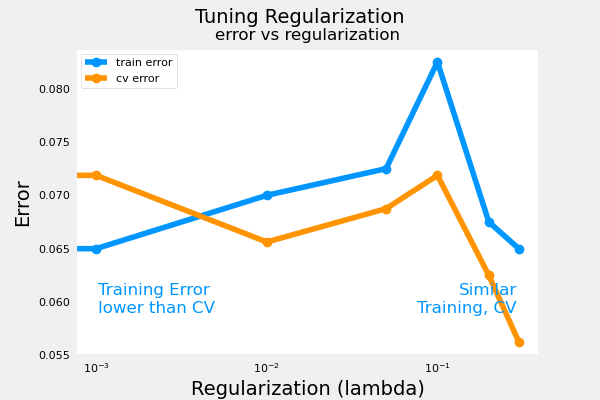

In [65]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

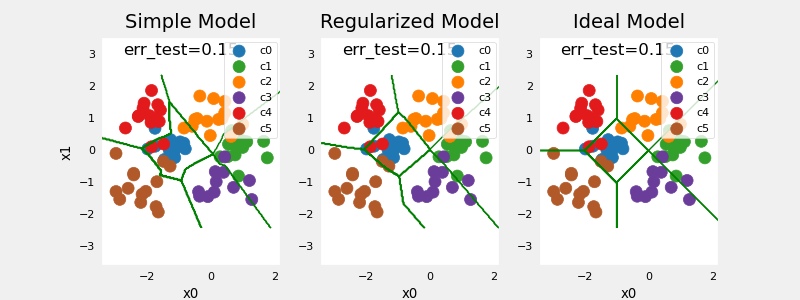

In [66]:
plt_compare(X_test, y_test, classes, model_predict_s, model_predict_r, centers)